# Understanding Customer Spending: A Data-Driven Credit Card Behavior Analysis

## 1.1 Project Overview

### Context

Delimiting credit card spending behavior is a common challenge in the financial industry. This task involves analyzing multiple aspects of credit card usage, such as balance, purchases, cash advances, credit limits, and total payments. Although credit card usage may seem random at first glance, there are patterns that can help infer and trace behavioral profiles based on these variables.

This study is based on a real-world dataset containing information from 9,000 credit card accounts that have been active in the last six months at a financial institution. The dataset includes 18 behavioral variables related to card usage. The marketing team aims to apply different marketing strategies tailored to specific customer groups.

### Objectives

The goal of this analysis is to derive meaningful insights from customer behavior data by creating new Key Performance Indicators (KPIs) and clustering clients based on their behavior. This will enable the marketing team to design targeted strategies for different customer segments. 

Our key objectives are:
- Construct enhanced customer behavior profiles by deriving new KPIs from the existing variables.
- Cluster customers into distinct behavioral segments based on their credit card usage patterns.
- Identify key characteristics of each cluster using detailed behavioral profiles.
- Provide strategic recommendations for targeted marketing based on the clustering results.

### Project Outline

This project will cover the following key techniques:
- **Data exploration and preprocessing**: Initial analysis and cleaning of the dataset.
- **Handling missing data**: Managing incomplete information effectively.
- **Outlier detection and treatment**: Identifying and mitigating outliers that could skew results.
- **KPI construction**: Developing new metrics to better capture customer behaviors.
- **Clustering model construction**: Grouping clients based on similar usage patterns using clustering algorithms.
- **Model evaluation**: Assessing the quality and effectiveness of the clustering model.


## 1.2. Data Description

This project involves developing a marketing strategy for different customer profiles. The dataset contains behavioral data for approximately 9,000 active credit card holders over the past six months. The data is provided at the customer level, with 18 variables capturing key aspects of credit card usage.

### Variables:

- **CUST_ID**: Unique identifier for each credit card holder.
- **BALANCE**: Monthly average balance (calculated based on daily balance averages).
- **BALANCE_FREQUENCY**: Ratio of months in the last year with a balance.
- **PURCHASES**: Total purchase amount spent over the last 12 months.
- **ONEOFF_PURCHASES**: Total amount spent on one-off purchases.
- **INSTALLMENTS_PURCHASES**: Total amount spent on installment purchases.
- **CASH_ADVANCE**: Total cash advance amount taken by the customer.
- **PURCHASES_FREQUENCY**: Frequency of purchases (percentage of months with at least one purchase).
- **ONEOFF_PURCHASES_FREQUENCY**: Frequency of one-off purchases over the period.
- **PURCHASES_INSTALLMENTS_FREQUENCY**: Frequency of installment purchases.
- **CASH_ADVANCE_FREQUENCY**: Frequency of cash advances.
- **AVERAGE_PURCHASE_TRX**: Average amount per purchase transaction.
- **CASH_ADVANCE_TRX**: Average amount per cash advance transaction.
- **PURCHASES_TRX**: Number of purchase transactions.
- **CREDIT_LIMIT**: Maximum credit limit for the cardholder.
- **PAYMENTS**: Total amount paid by the customer to reduce their balance during the period.
- **MINIMUM_PAYMENTS**: Total minimum payments required over the period.
- **PRC_FULL_PAYMENT**: Percentage of months where the customer fully paid off the balance.
- **TENURE**: Number of months the customer has held the credit card.

## 2. Importing libraries

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
from matplotlib import style
style.use('ggplot')
from warnings import filterwarnings
filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8,6)

## 2.1. Loading auxiliary functions

In [3]:
def create_summary(x):
    """
    Generate summary statistics for a given pandas Series.

    Parameters:
    - x: Input pandas Series.

    Returns:
    - summary: A pandas Series containing the count, missing values, sum, mean, 
               median, standard deviation, variance, minimum, quantiles, and maximum.
    """
    return pd.Series(
        [
            x.count(),
            x.isnull().sum(),
            x.sum(),
            x.mean(),
            x.median(),
            x.std(),
            x.var(),
            x.min(),
            x.quantile(0.01),
            x.quantile(0.05),
            x.quantile(0.10),
            x.quantile(0.25),
            x.quantile(0.50),
            x.quantile(0.75),
            x.quantile(0.90),
            x.quantile(0.95),
            x.quantile(0.99),
            x.max()
        ], 
        index=[
            'N', 'NMISS', 'SUM', 'MEAN', 'MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
            'P5', 'P10', 'P25', 'P50', 'P75', 'P90', 'P95', 'P99', 'MAX'
        ]
    )

In [4]:
def corrMat(df):
    """
    Generate a correlation heatmap for the numeric columns of a DataFrame, 
    with columns renamed to title case and underscores replaced by spaces.

    Parameters:
    - df: Input DataFrame.

    Returns:
    - Displays a heatmap of the correlation matrix.
    """
    numeric_df = df.select_dtypes(include=[np.number])
    renamed_columns = {col: col.replace('_', ' ').title() for col in numeric_df.columns}
    numeric_df = numeric_df.rename(columns=renamed_columns)
    
    corr_mat = numeric_df.corr().round(2)
    
    sns.set(style="white")
    f, ax = plt.subplots(figsize=(6, 6))
    
    mask = np.zeros_like(corr_mat, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    sns.heatmap(
        corr_mat, 
        mask=mask, 
        vmin=-1, 
        vmax=1, 
        center=0, 
        cmap='coolwarm', 
        square=False, 
        lw=2, 
        annot=True, 
        cbar=True, 
        annot_kws={"size": 8, "weight": "bold"}
    )
    
    plt.title('Credit Card Customer Behaviour Correlation Heatmap')
    plt.show()

In [6]:
def plot_boxplots(df):
    """
    Generate a grid of boxplots for each numeric column in a DataFrame.

    The function selects all numeric columns from the input DataFrame, and 
    creates a grid of boxplots to visualize the distribution and potential outliers.
    Each plot's title is set to the corresponding column name.

    Parameters:
    - df: Input DataFrame containing numeric columns.

    Returns:
    - Displays a grid of boxplots for each numeric column.
    """
    numeric_df = df.select_dtypes(include='number')
    
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
    axes = axes.flatten()

    for i, column in enumerate(numeric_df.columns):
        sns.boxplot(data=numeric_df, x=column, ax=axes[i], 
                    flierprops=dict(marker='o', markerfacecolor='black', markersize=6),
                    color='mediumpurple')
        axes[i].set_title(column, fontsize=14)
        axes[i].set_xlabel('')

    # Hide any remaining axes if columns < grid size
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.ylabel('Value', fontsize=14)
    plt.tight_layout()
    plt.show()

## 2.2. Data importing

In [7]:
df = pd.read_csv('../data/CC_GENERAL.csv')

In [8]:
df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [9]:
df.shape

(8950, 18)

In [11]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

In [12]:
num_features = df.select_dtypes([np.number])

In [13]:
num_features.apply(create_summary).T

N  NMISS           SUM         MEAN  \
BALANCE                           8950.0    0.0  1.400205e+07  1564.474828   
BALANCE_FREQUENCY                 8950.0    0.0  7.851573e+03     0.877271   
PURCHASES                         8950.0    0.0  8.978683e+06  1003.204834   
ONEOFF_PURCHASES                  8950.0    0.0  5.302314e+06   592.437371   
INSTALLMENTS_PURCHASES            8950.0    0.0  3.679055e+06   411.067645   
CASH_ADVANCE                      8950.0    0.0  8.760896e+06   978.871112   
PURCHASES_FREQUENCY               8950.0    0.0  4.388637e+03     0.490351   
ONEOFF_PURCHASES_FREQUENCY        8950.0    0.0  1.811996e+03     0.202458   
PURCHASES_INSTALLMENTS_FREQUENCY  8950.0    0.0  3.261714e+03     0.364437   
CASH_ADVANCE_FREQUENCY            8950.0    0.0  1.209541e+03     0.135144   
CASH_ADVANCE_TRX                  8950.0    0.0  2.907700e+04     3.248827   
PURCHASES_TRX                     8950.0    0.0  1.316530e+05    14.709832   
CREDIT_LIMIT                      8949.0    1.0  4.022083e+07  4494.449450   
PAYMENTS                          8950.0    0.0  1.551164e+07  1733.143852   
MINIMUM_PAYMENTS                  8637.0  313.0  7.464152e+06   864.206542   
PRC_FULL_PAYMENT                  8950.0    0.0  1.375746e+03     0.153715   
TENURE                            8950.0    0.0  1.030800e+05    11.517318   

                                       MEDIAN          STD           VAR  \
BALANCE                            873.385231  2081.531879  4.332775e+06   
BALANCE_FREQUENCY                    1.000000     0.236904  5.612351e-02   
PURCHASES                          361.280000  2136.634782  4.565208e+06   
ONEOFF_PURCHASES                    38.000000  1659.887917  2.755228e+06   
INSTALLMENTS_PURCHASES              89.000000   904.338115  8.178274e+05   
CASH_ADVANCE                         0.000000  2097.163877  4.398096e+06   
PURCHASES_FREQUENCY                  0.500000     0.401371  1.610985e-01   
ONEOFF_PURCHASES_FREQUENCY           0.083333     0.298336  8.900441e-02   
PURCHASES_INSTALLMENTS_FREQUENCY     0.166667     0.397448  1.579647e-01   
CASH_ADVANCE_FREQUENCY               0.000000     0.200121  4.004857e-02   
CASH_ADVANCE_TRX                     0.000000     6.824647  4.657580e+01   
PURCHASES_TRX                        7.000000    24.857649  6.179027e+02   
CREDIT_LIMIT                      3000.000000  3638.815725  1.324098e+07   
PAYMENTS                           856.901546  2895.063757  8.381394e+06   
MINIMUM_PAYMENTS                   312.343947  2372.446607  5.628503e+06   
PRC_FULL_PAYMENT                     0.000000     0.292499  8.555578e-02   
TENURE                              12.000000     1.338331  1.791129e+00   

                                        MIN          P1           P5  \
BALANCE                            0.000000    0.065101     8.814518   
BALANCE_FREQUENCY                  0.000000    0.090909     0.272727   
PURCHASES                          0.000000    0.000000     0.000000   
ONEOFF_PURCHASES                   0.000000    0.000000     0.000000   
INSTALLMENTS_PURCHASES             0.000000    0.000000     0.000000   
CASH_ADVANCE                       0.000000    0.000000     0.000000   
PURCHASES_FREQUENCY                0.000000    0.000000     0.000000   
ONEOFF_PURCHASES_FREQUENCY         0.000000    0.000000     0.000000   
PURCHASES_INSTALLMENTS_FREQUENCY   0.000000    0.000000     0.000000   
CASH_ADVANCE_FREQUENCY             0.000000    0.000000     0.000000   
CASH_ADVANCE_TRX                   0.000000    0.000000     0.000000   
PURCHASES_TRX                      0.000000    0.000000     0.000000   
CREDIT_LIMIT                      50.000000  500.000000  1000.000000   
PAYMENTS                           0.000000    0.000000    89.988924   
MINIMUM_PAYMENTS                   0.019163   19.524478    73.282006   
PRC_FULL_PAYMENT                   0.000000    0.000000     0.000000   
TENURE                             6.0000

In [14]:
df.describe(exclude=[np.number])

CUST_ID
count     8950
unique    8950
top     C10001
freq         1

We will remove the `CUST_ID` column from the dataset, as it is a unique identifier and does not provide any predictive value for our model building process.

In [15]:
df.drop('CUST_ID', axis=1, inplace=True)

## 3.1. Handling missing data

In [16]:
count_missing = df.isnull().sum() 

percent_missing = (df.isnull().sum()/len(df))*100

missing_values = pd.concat([percent_missing,count_missing], axis=1,
                           keys=['Percent_of_Missing_Values', 'Count_of_Missing_Values'])
missing_values

Percent_of_Missing_Values  \
BALANCE                                            0.000000   
BALANCE_FREQUENCY                                  0.000000   
PURCHASES                                          0.000000   
ONEOFF_PURCHASES                                   0.000000   
INSTALLMENTS_PURCHASES                             0.000000   
CASH_ADVANCE                                       0.000000   
PURCHASES_FREQUENCY                                0.000000   
ONEOFF_PURCHASES_FREQUENCY                         0.000000   
PURCHASES_INSTALLMENTS_FREQUENCY                   0.000000   
CASH_ADVANCE_FREQUENCY                             0.000000   
CASH_ADVANCE_TRX                                   0.000000   
PURCHASES_TRX                                      0.000000   
CREDIT_LIMIT                                       0.011173   
PAYMENTS                                           0.000000   
MINIMUM_PAYMENTS                                   3.497207   
PRC_FULL_PAYMENT                                   0.000000   
TENURE                                             0.000000   

                                  Count_of_Missing_Values  
BALANCE                                                 0  
BALANCE_FREQUENCY                                       0  
PURCHASES                                               0  
ONEOFF_PURCHASES                                        0  
INSTALLMENTS_PURCHASES                                  0  
CASH_ADVANCE                                            0  
PURCHASES_FREQUENCY                                     0  
ONEOFF_PURCHASES_FREQUENCY                              0  
PURCHASES_INSTALLMENTS_FREQUENCY                        0  
CASH_ADVANCE_FREQUENCY                                  0  
CASH_ADVANCE_TRX                                        0  
PURCHASES_TRX                                           0  
CREDIT_LIMIT                                            1  
PAYMENTS                                                0  
MINIMUM_PAYMENTS                                      313  
PRC_FULL_PAYMENT                                        0  
TENURE                                                  0

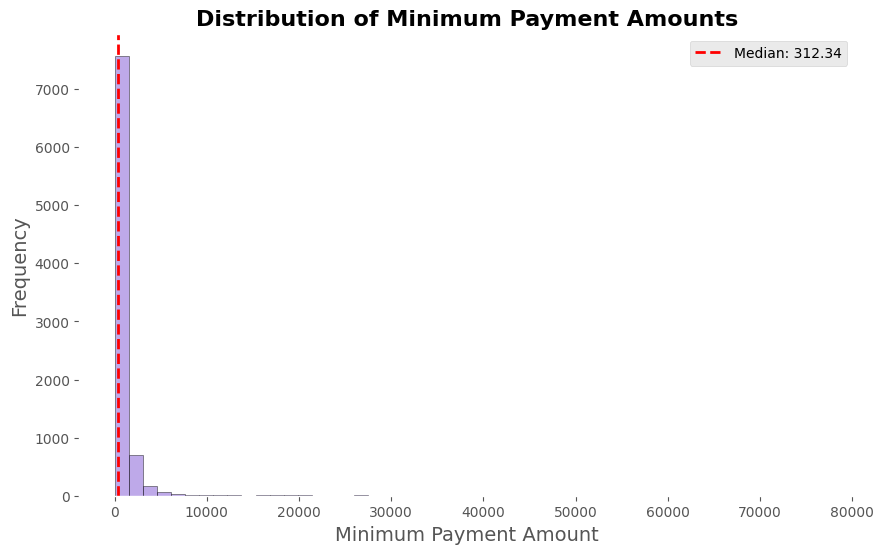

In [17]:
median_value = df['MINIMUM_PAYMENTS'].dropna().median()

fig, ax = plt.subplots(figsize=(10, 6))

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

ax.hist(df['MINIMUM_PAYMENTS'].dropna(), bins=50, color='mediumpurple', edgecolor='black', alpha=0.6)

ax.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

ax.set_title('Distribution of Minimum Payment Amounts', fontsize=16, fontweight='bold')
ax.set_xlabel('Minimum Payment Amount', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

ax.grid(False)

ax.legend()

plt.show()

Upon analyzing the missing data, we found that 3.5% of the values are missing in the **Minimum Payment** column, while the **Credit Limit** column has only one missing value (0.011%). Since the missing value in the **Credit Limit** column is isolated, it is more efficient to drop this single entry.

For the **Minimum Payment** column, the distribution is highly skewed to the left, with a high concentration of values around the median. Given this skewness, imputing the missing values with the median is a practical and parsimonious solution, as the median is more robust to extreme values compared to the mean, and it better represents the central tendency of this skewed distribution.


In [18]:
#Dropping the null entry in Credit Limit
df = df.dropna(subset=['CREDIT_LIMIT'])
df = df.reset_index(drop=True)

In [19]:
#Inputting values with the median values of Minimun Payments
df['MINIMUM_PAYMENTS']= df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median())

In [20]:
count_missing = df.isnull().sum() 

percent_missing = (df.isnull().sum()/len(df))*100

missing_values = pd.concat([percent_missing,count_missing], axis=1,
                           keys=['Percent_of_Missing_Values', 'Count_of_Missing_Values'])
missing_values

Percent_of_Missing_Values  \
BALANCE                                                 0.0   
BALANCE_FREQUENCY                                       0.0   
PURCHASES                                               0.0   
ONEOFF_PURCHASES                                        0.0   
INSTALLMENTS_PURCHASES                                  0.0   
CASH_ADVANCE                                            0.0   
PURCHASES_FREQUENCY                                     0.0   
ONEOFF_PURCHASES_FREQUENCY                              0.0   
PURCHASES_INSTALLMENTS_FREQUENCY                        0.0   
CASH_ADVANCE_FREQUENCY                                  0.0   
CASH_ADVANCE_TRX                                        0.0   
PURCHASES_TRX                                           0.0   
CREDIT_LIMIT                                            0.0   
PAYMENTS                                                0.0   
MINIMUM_PAYMENTS                                        0.0   
PRC_FULL_PAYMENT                                        0.0   
TENURE                                                  0.0   

                                  Count_of_Missing_Values  
BALANCE                                                 0  
BALANCE_FREQUENCY                                       0  
PURCHASES                                               0  
ONEOFF_PURCHASES                                        0  
INSTALLMENTS_PURCHASES                                  0  
CASH_ADVANCE                                            0  
PURCHASES_FREQUENCY                                     0  
ONEOFF_PURCHASES_FREQUENCY                              0  
PURCHASES_INSTALLMENTS_FREQUENCY                        0  
CASH_ADVANCE_FREQUENCY                                  0  
CASH_ADVANCE_TRX                                        0  
PURCHASES_TRX                                           0  
CREDIT_LIMIT                                            0  
PAYMENTS                                                0  
MINIMUM_PAYMENTS                                        0  
PRC_FULL_PAYMENT                                        0  
TENURE                                                  0

## 3.2. Treating outliers

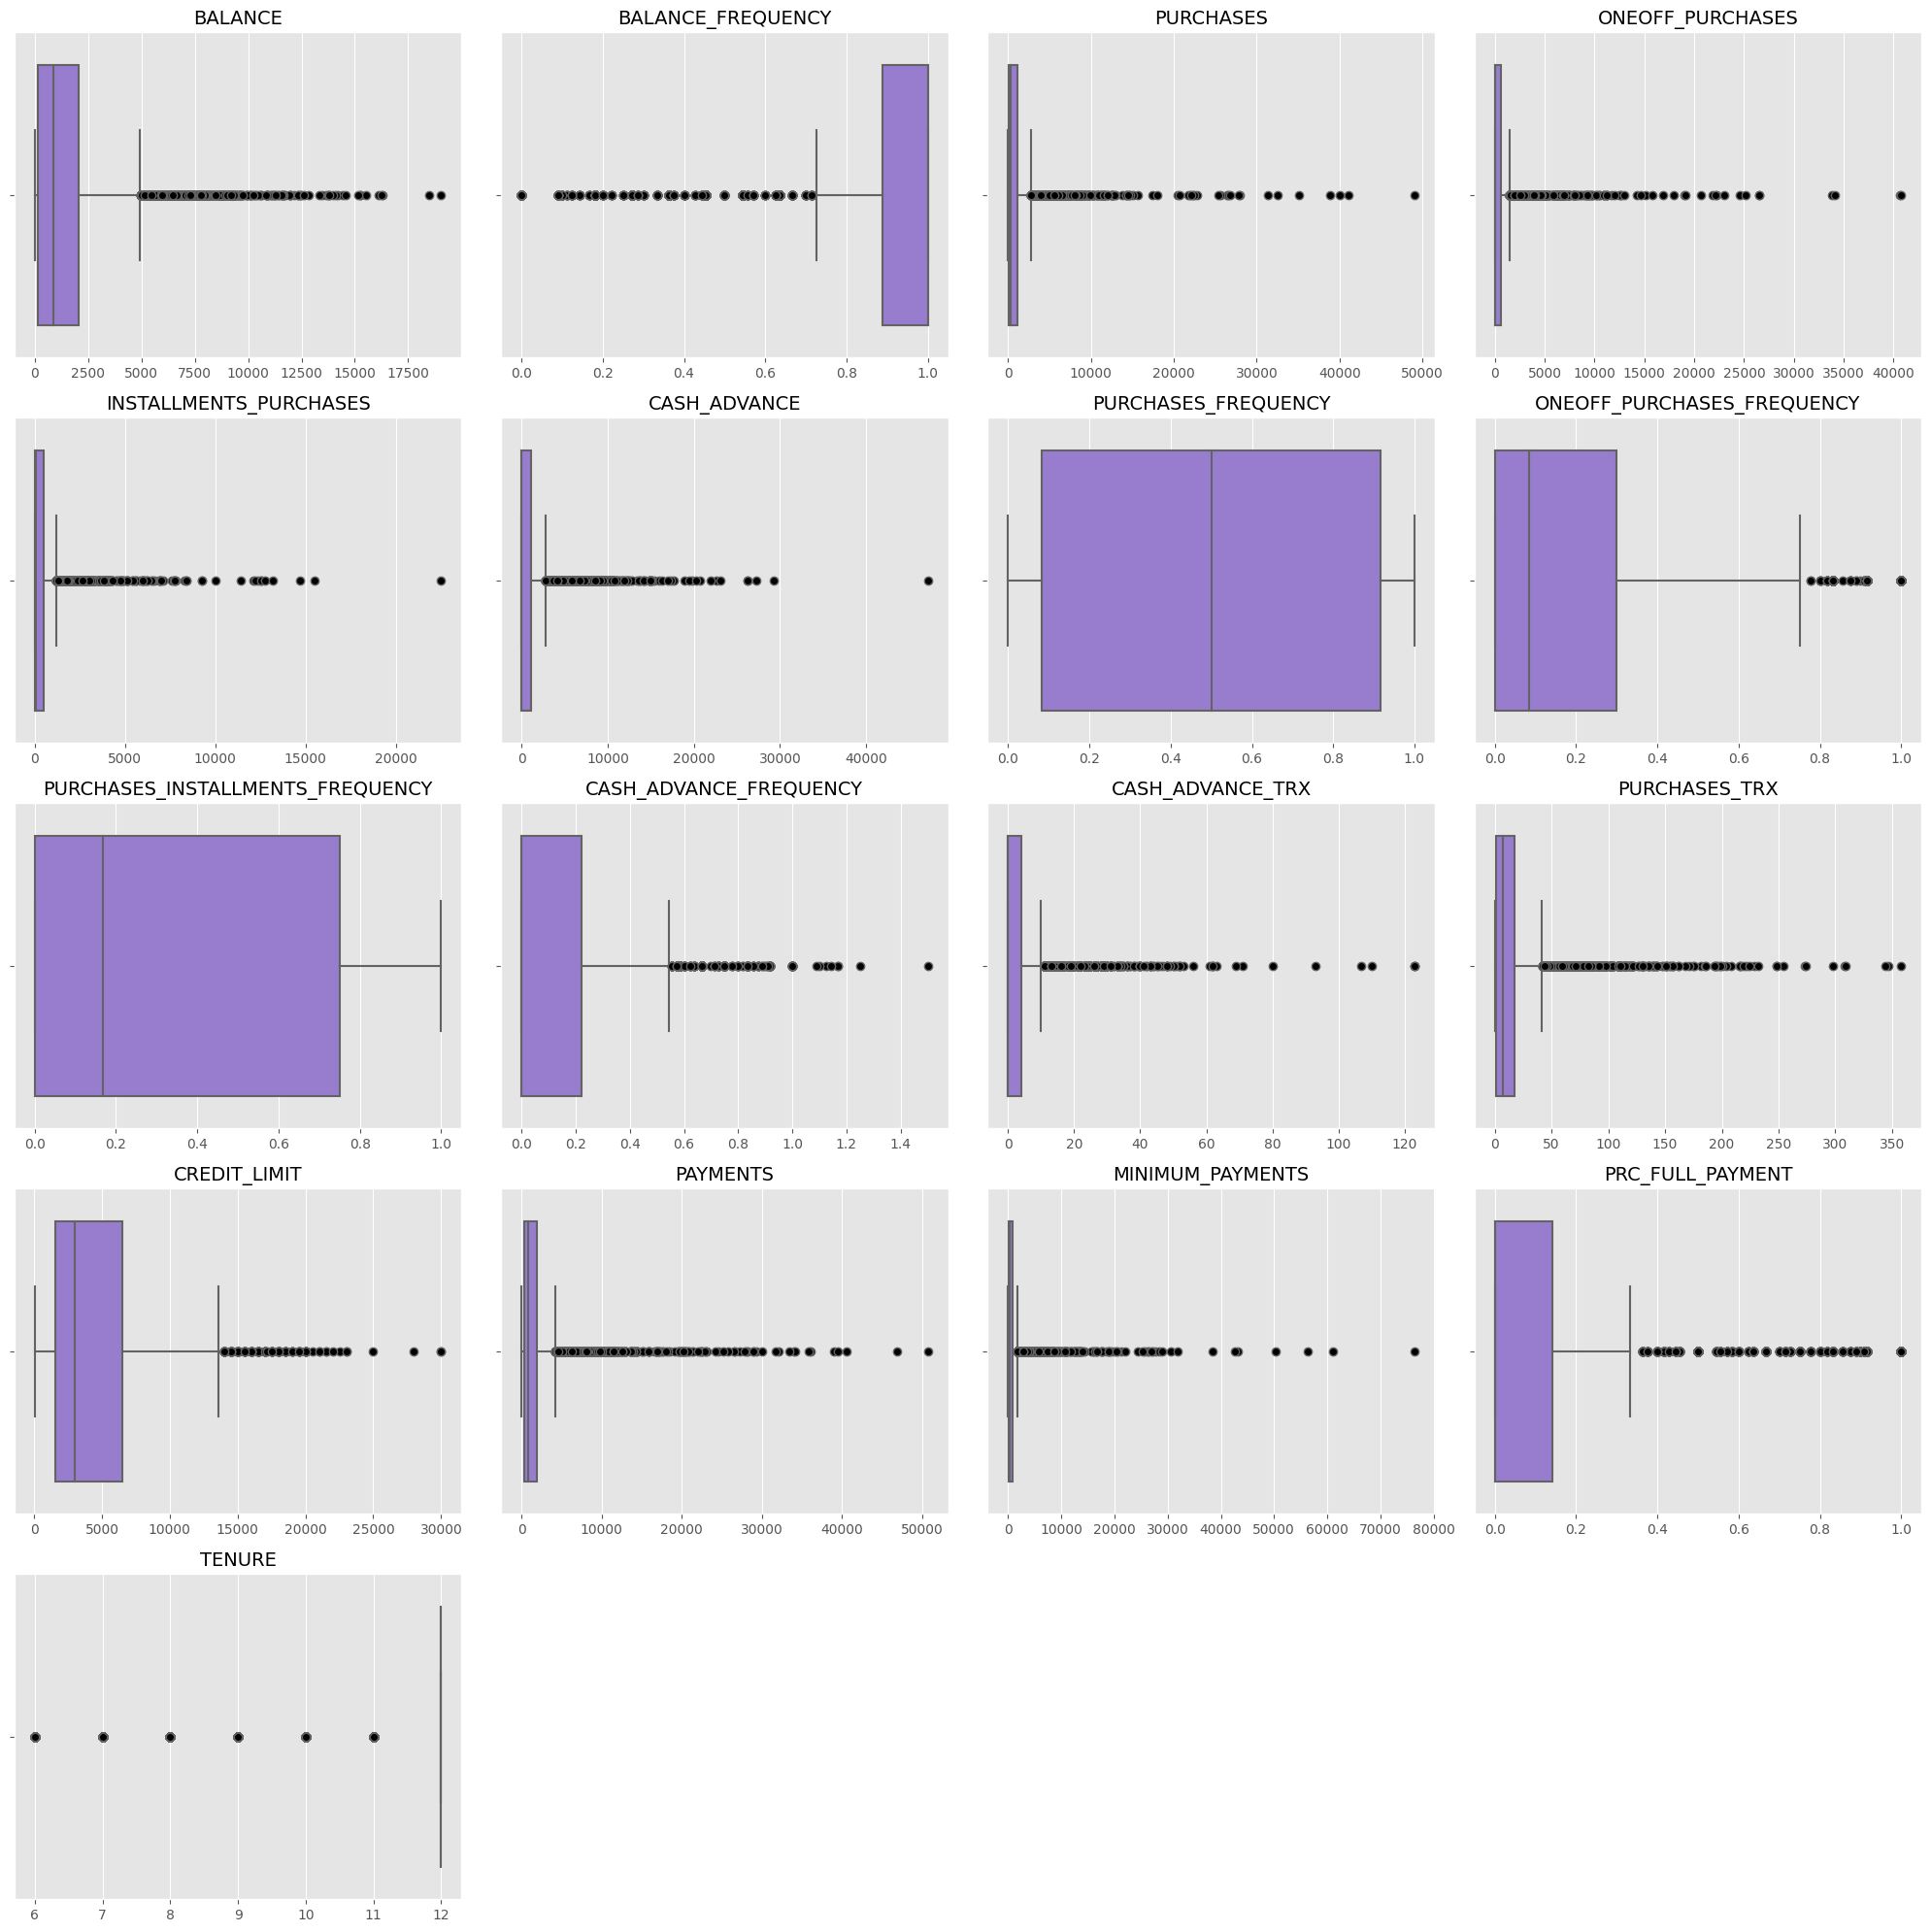

In [21]:
numeric_df = df.select_dtypes(include='number')

plot_boxplots(numeric_df)

We observe from the boxplots above that outliers are indeed present across several features. Addressing these outliers is crucial for maintaining the integrity of our analysis and improving model performance.

#### Handling Outliers Using the Interquartile Range (IQR) Method

To address outliers in the dataset, I propose applying the **Interquartile Range (IQR) Method** for the following reasons:

#### 1. Robustness
The IQR method focuses on the middle 50% of the data (between the 1st and 3rd quartiles). This makes it **less sensitive to extreme values** compared to methods that rely on the mean and standard deviation. By using this method, we are better able to detect genuine patterns in the data without being skewed by outliers.

#### 2. Efficiency
The IQR method is **straightforward and computationally efficient**, allowing us to easily identify and remove or cap outliers. It involves calculating the range between the 25th percentile (Q1) and the 75th percentile (Q3), and then flagging any values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR as outliers.

#### 3. Broad Applicability
This approach works well for a wide range of data distributions, including those with **skewness**, which is common in our dataset. The IQR method is non-parametric, meaning it does not assume a specific distribution, making it widely applicable.

In [22]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = scaler.fit_transform(df)
print(scaler.fit_transform(df))

[[-0.43238654 -1.63636364 -0.24859628 ... -0.27991199  0.
   0.        ]
 [ 1.209127   -0.81818182 -0.33772434 ...  1.2298986   1.55555556
   0.        ]
 [ 0.84188091  0.          0.38461467 ...  0.50956468  0.
   0.        ]
 ...
 [-0.44147377 -1.5000045  -0.20281772 ... -0.37231596  1.75000175
  -6.        ]
 [-0.44663529 -1.5000045  -0.33772434 ... -0.4154703   1.75000175
  -6.        ]
 [-0.26010922 -3.          0.68365145 ... -0.36281426  0.
  -6.        ]]


In [23]:
df.shape

(8949, 17)

## 3.3 Building Key Performance Indicators (KPI's) to better understand customer profiles.

### 3.3.1. Monthly Average Purchase

##### Monthly Average Purchase KPI

The **Monthly Average Purchase** is a key performance indicator (KPI) that measures the average amount spent by a customer on purchases each month. It is calculated by dividing the total purchases made by the customer (`PURCHASES`) by the total tenure of the customer relationship in months (`TENURE`).

##### Interpretation
- **Customer Spending Behavior**: This KPI provides insights into the spending behavior of customers. A higher value indicates that customers are spending more on average each month.

In [24]:
monthly_average_purchase = df['PURCHASES'] / df['TENURE']
print(monthly_average_purchase)

0         7.950000
1         0.000000
2        64.430833
3       124.916667
4         1.333333
           ...    
8944     48.520000
8945     50.000000
8946     24.066667
8947      0.000000
8948    182.208333
Length: 8949, dtype: float64


In [25]:
df['MONTHLY_AVG_PURCHASES'] = monthly_average_purchase

### 3.3.2. Monthly Average Cash Advance Amount

##### Monthly Average Cash Advance KPI

The **Monthly Average Cash Advance** is a key performance indicator (KPI) that measures the average amount of cash withdrawn by a customer each month. It is calculated by dividing the total cash advances made by the customer (`CASH_ADVANCE`) by the total tenure of the customer relationship in months (`TENURE`).

##### Interpretation
- **Customer Cash Withdrawal Behavior**: This KPI provides insights into how often and how much customers are utilizing cash advances. A higher average indicates that customers are relying more on cash advances, which may reflect their financial needs or spending behavior.

In [26]:
monthly_average_cash = df['CASH_ADVANCE'] / df['TENURE']
print(monthly_average_cash)

0         0.000000
1       536.912124
2         0.000000
3        17.149001
4         0.000000
           ...    
8944      0.000000
8945      0.000000
8946      0.000000
8947      6.093130
8948     21.173335
Length: 8949, dtype: float64


In [27]:
df['AVG_CASH_ADVANCE'] = monthly_average_cash

### 3.3.3. Division of Customer by type of Purchases 

These categories were created to classify customers based on their purchasing behavior. By separating them into distinct types (no purchases, one-off only, installment only, or both), one can analyze trends and target marketing or customer retention strategies based on how individuals prefer to make purchases.

1. **None_Of_the_Purchases**:
   - **Condition**: `(df['ONEOFF_PURCHASES'] == 0) & (df['INSTALLMENTS_PURCHASES'] == 0)`
   - **Explanation**: This category represents customers who made neither one-off purchases nor installment purchases.

2. **One_Of_Purchase**:
   - **Condition**: `(df['ONEOFF_PURCHASES'] > 0) & (df['INSTALLMENTS_PURCHASES'] == 0)`
   - **Explanation**: This category includes customers who made only one-off purchases but no installment purchases.

3. **Installment_Purchases**:
   - **Condition**: `(df['ONEOFF_PURCHASES'] == 0) & (df['INSTALLMENTS_PURCHASES'] > 0)`
   - **Explanation**: This category represents customers who only made installment purchases without any one-off purchases.

4. **Both_the_Purchases**:
   - **Condition**: `(df['ONEOFF_PURCHASES'] > 0) & (df['INSTALLMENTS_PURCHASES'] > 0)`
   - **Explanation**: This category represents customers who made both one-off and installment purchases.

In [28]:
df_type_purchases = df[['ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES']]
df_type_purchases

ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES
0                 0.00                   95.40
1                 0.00                    0.00
2               773.17                    0.00
3              1499.00                    0.00
4                16.00                    0.00
...                ...                     ...
8944              0.00                  291.12
8945              0.00                  300.00
8946              0.00                  144.40
8947              0.00                    0.00
8948           1093.25                    0.00

[8949 rows x 2 columns]

In [29]:
df_type_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8949 entries, 0 to 8948
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ONEOFF_PURCHASES        8949 non-null   float64
 1   INSTALLMENTS_PURCHASES  8949 non-null   float64
dtypes: float64(2)
memory usage: 140.0 KB


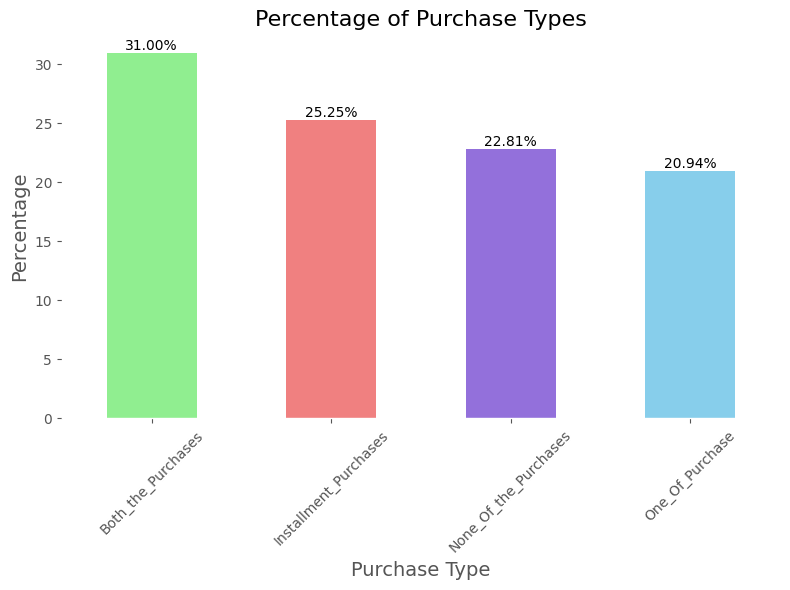

In [30]:
df['Purchase_Type'] = np.where(
    (df['ONEOFF_PURCHASES'] == 0) & (df['INSTALLMENTS_PURCHASES'] == 0), 'None_Of_the_Purchases',
    np.where(
        (df['ONEOFF_PURCHASES'] > 0) & (df['INSTALLMENTS_PURCHASES'] == 0), 'One_Of_Purchase',
        np.where(
            (df['ONEOFF_PURCHASES'] == 0) & (df['INSTALLMENTS_PURCHASES'] > 0), 'Installment_Purchases',
            'Both_the_Purchases'
        )
    )
)

purchase_type_counts = df['Purchase_Type'].value_counts(normalize=True) * 100

color_mapping = {
    'None_Of_the_Purchases': 'mediumpurple',
    'One_Of_Purchase': 'skyblue',
    'Installment_Purchases': 'lightcoral',
    'Both_the_Purchases': 'lightgreen'
}

colors = [color_mapping[purchase_type] for purchase_type in purchase_type_counts.index]

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

purchase_type_counts.plot(kind='bar', color=colors, ax=ax)

ax.set_title('Percentage of Purchase Types', fontsize=16)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_xlabel('Purchase Type', fontsize=14)
plt.xticks(rotation=45)

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f%%')

plt.tight_layout()
plt.show()

Approximately 31% of customers engage in both one-off and installment purchases, while 25.3% exclusively make installment purchases

### 3.3.4. Estimating the limit usage of customers 

##### Limit_Usage Variable:

- **Formula**: `df['Limit_Usage'] = df['BALANCE'] / df['CREDIT_LIMIT']`
  
- **Explanation**: 
   - This variable represents the proportion of the available credit that a customer has utilized. It is calculated by dividing the current balance (`BALANCE`) by the total credit limit (`CREDIT_LIMIT`).
   - A higher value indicates that a customer is using a larger portion of their credit, which may suggest higher financial activity or potential risk in terms of credit management.
   - On the other hand, a lower value indicates that the customer is using less of their credit limit, which might suggest financial stability or less reliance on credit.

##### Why This Calculation?
- **Credit Utilization**: The `Limit_Usage` variable helps in understanding credit utilization, a critical factor in financial analysis and risk assessment.
- **Behavior Insight**: It allows us to gauge how much of their credit line customers are using. This feature can be useful in segmentation and clustering analysis to group customers based on their credit usage behavior.

In [31]:
df['Limit_Usage'] = df['BALANCE']/df['CREDIT_LIMIT']
df['Limit_Usage']

0       0.040901
1       0.457495
2       0.332687
3       0.222223
4       0.681429
          ...   
8944    0.028494
8945    0.019183
8946    0.023399
8947    0.026915
8948    0.310590
Name: Limit_Usage, Length: 8949, dtype: float64

### 3.3.5. Estimating Customer Payments to Minimum Payments Ratio 

##### Pay_to_MinimumPay Variable:

- **Formula**: `df['Pay_to_MinimumPay'] = df['PAYMENTS'] / df['MINIMUM_PAYMENTS']`
  
- **Explanation**: 
   - This variable represents the ratio of the total payments made by a customer (`PAYMENTS`) to the minimum payments required (`MINIMUM_PAYMENTS`). 
   - A value greater than 1 means the customer is paying more than the minimum, indicating strong financial discipline and a desire to reduce their outstanding balance faster.
   - A value equal to 1 means the customer is paying exactly the minimum, which is meeting the requirements but not reducing the balance significantly.
   - A value less than 1 indicates that the customer is paying less than the minimum, which could signal financial difficulties or delinquency.

##### Why This Calculation?
- **Payment Behavior Insight**: The `Pay_to_MinimumPay` variable helps assess a customer's payment behavior, offering insights into their creditworthiness and financial responsibility.
- **Risk Assessment**: This feature is crucial for risk profiling and can be useful in identifying customers who may be at risk of default if they consistently pay less than the minimum required.

In [32]:
df['Pay_to_MinimumPay'] = df['PAYMENTS']/df['MINIMUM_PAYMENTS']
df['Pay_to_MinimumPay']

0       1.446508
1       3.826241
2       0.991682
3       0.000000
4       2.771075
          ...   
8944    6.660231
8945    0.882891
8946    0.986076
8947    0.942505
8948    0.715439
Name: Pay_to_MinimumPay, Length: 8949, dtype: float64

### 3.3.6. Gainning insights from Purchase Type KPI

I) Minimum Pay per Purchase Type

In [33]:
minimun_pay_PT = df.groupby(by=["Purchase_Type"])['Pay_to_MinimumPay'].mean().sort_values(ascending = False)
minimun_pay_PT

Purchase_Type
Installment_Purchases    13.258996
None_Of_the_Purchases    10.092080
Both_the_Purchases        7.236979
One_Of_Purchase           5.571042
Name: Pay_to_MinimumPay, dtype: float64

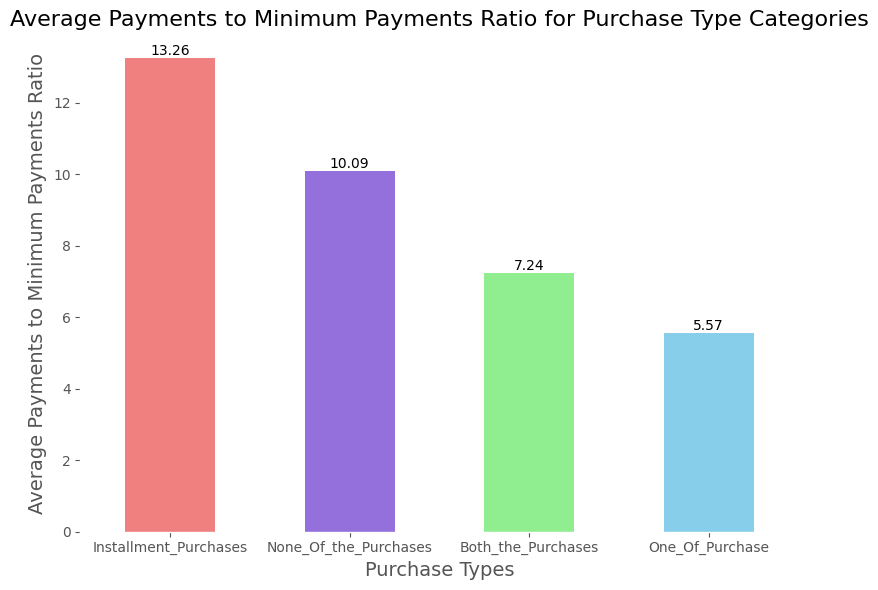

In [34]:

color_mapping = {
    'None_Of_the_Purchases': 'mediumpurple',
    'One_Of_Purchase': 'skyblue',
    'Installment_Purchases': 'lightcoral',
    'Both_the_Purchases': 'lightgreen'
}




colors = [color_mapping.get(purchase_type, 'gray') for purchase_type in minimun_pay_PT.index]


fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')


minimun_pay_PT.plot(kind='bar', color=colors, ax=ax)


ax.set_title('Average Payments to Minimum Payments Ratio for Purchase Type Categories', fontsize=16)
ax.set_xlabel('Purchase Types', fontsize=14)
ax.set_ylabel('Average Payments to Minimum Payments Ratio', fontsize=14)
ax.set_xticklabels(minimun_pay_PT.index, rotation=0)


for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')


plt.tight_layout()
plt.show()

In [35]:
df.groupby(by=["Purchase_Type"])['Pay_to_MinimumPay'].describe()

count       mean         std  min       25%       50%  \
Purchase_Type                                                                   
Both_the_Purchases     2774.0   7.236979   12.355699  0.0  1.179504  3.794833   
Installment_Purchases  2260.0  13.258996  214.712834  0.0  0.933728  1.925054   
None_Of_the_Purchases  2041.0  10.092080   99.195036  0.0  0.736568  1.118858   
One_Of_Purchase        1874.0   5.571042   12.085110  0.0  0.875735  1.874382   

                            75%          max  
Purchase_Type                                 
Both_the_Purchases     9.194374   397.517256  
Installment_Purchases  4.507115  6840.528861  
None_Of_the_Purchases  3.756854  2846.533661  
One_Of_Purchase        5.781624   221.734944

##### Insights:

- **Highest Payments in Installment Purchases**:  
  Customers who make installment purchases show the highest average payments relative to their minimum payments, with a ratio of 13.93. This indicates that customers in this group tend to pay significantly more than the required minimum, which might reflect a preference for long-term payment strategies with larger financial commitments.

- **Moderate Payments in 'None' and 'Both' Purchase Types**:  
  Both "None_Of_the_Purchases" and "Both_the_Purchases" groups have moderate payments above the minimum, with ratios of 10.46 and 7.31, respectively. These customers likely manage their payments in a more balanced way, avoiding both extremes of paying too little or too much beyond the minimum.

- **Lowest Payments in One-Off Purchases**:  
  The "One_Of_Purchase" group shows the lowest average payments relative to the minimum, with a ratio of 5.74. This suggests that customers making one-off purchases are more likely to pay closer to the minimum amount, which could indicate a more cautious approach to credit use, or possibly more conservative financial behavior.

- **Variance in Installment Purchases**:  
  The high average for installment purchases, coupled with significant variability, could indicate the presence of outliers or individuals who make large payments beyond the minimum. This may point to a smaller group of financially aggressive payers or require further investigation to assess whether such high payments are common in this group.

II) Credit Limit Balance per Purchase Type

In [36]:
balance_credit_limit_PT = df.groupby(['Purchase_Type'])['Limit_Usage'].mean().sort_values(ascending = True).reset_index()
balance_credit_limit_PT

Purchase_Type  Limit_Usage
0  Installment_Purchases     0.271678
1     Both_the_Purchases     0.353548
2        One_Of_Purchase     0.381074
3  None_Of_the_Purchases     0.574049

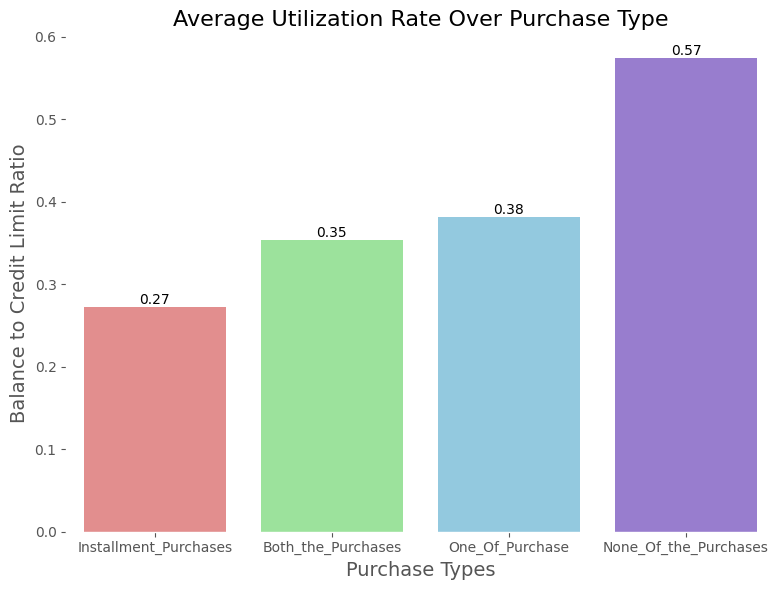

In [37]:
color_mapping = {
    'None_Of_the_Purchases': 'mediumpurple',
    'One_Of_Purchase': 'skyblue',
    'Installment_Purchases': 'lightcoral',
    'Both_the_Purchases': 'lightgreen'
}

colors = [color_mapping[purchase_type] for purchase_type in balance_credit_limit_PT['Purchase_Type']]

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

sns.barplot(x=balance_credit_limit_PT['Purchase_Type'], 
            y=balance_credit_limit_PT['Limit_Usage'], 
            palette=colors, 
            ax=ax)

ax.set_title('Average Utilization Rate Over Purchase Type', fontsize=16)
ax.set_xlabel('Purchase Types', fontsize=14)
ax.set_ylabel('Balance to Credit Limit Ratio', fontsize=14)
ax.set_xticklabels(balance_credit_limit_PT['Purchase_Type'], rotation=0)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [38]:
df.groupby(['Purchase_Type'])['Limit_Usage'].describe()

count      mean       std  min       25%       50%  \
Purchase_Type                                                                
Both_the_Purchases     2774.0  0.353548  0.315545  0.0  0.065303  0.272681   
Installment_Purchases  2260.0  0.271678  0.369372  0.0  0.009465  0.048766   
None_Of_the_Purchases  2041.0  0.574049  0.466042  0.0  0.306330  0.606633   
One_Of_Purchase        1874.0  0.381074  0.348179  0.0  0.039105  0.297733   

                            75%        max  
Purchase_Type                               
Both_the_Purchases     0.591074   1.570210  
Installment_Purchases  0.488272   2.033580  
None_Of_the_Purchases  0.870958  15.909951  
One_Of_Purchase        0.706577   1.374434

#### Insights:

- **Balance-to-Limit Ratios**:  
  The **Both_the_Purchases** group has a balance-to-limit ratio of **0.3535**, indicating a moderate level of credit utilization. This suggests that these customers are managing their credit effectively.  
  The **Installment_Purchases** group displays the lowest balance-to-limit ratio of **0.2717**, reflecting a favorable credit risk profile, as lower ratios are desirable. This indicates that customers making installment purchases maintain lower utilization rates, potentially signaling better credit management.  
  The **None_Of_the_Purchases** group has a higher ratio of **0.5740**, which could indicate a more significant credit risk, as they are utilizing over half of their available credit.  
  Finally, the **One_Of_Purchase** group shows a balance-to-limit ratio of **0.3811**, suggesting a moderate level of credit use that could warrant further monitoring.

- **KPI Summary**:  
  - **Both_the_Purchases**: Average Payment = **2774.0**, Balance-to-Limit Ratio = **0.3535**  
  - **Installment_Purchases**: Average Payment = **2260.0**, Balance-to-Limit Ratio = **0.2717**  
  - **None_Of_the_Purchases**: Average Payment = **2041.0**, Balance-to-Limit Ratio = **0.5740**  
  - **One_Of_Purchase**: Average Payment = **1874.0**, Balance-to-Limit Ratio = **0.3811**  

- **Credit Risk Insight**:  
  A lower balance-to-limit ratio is desirable, indicating lower credit risk. The customers who make installment purchases have the lowest utilization rate, suggesting better financial health and management of credit.


III) Monthly Average Purchase per Purchase Type

In [39]:
monthly_avg_purchases_PT = df.groupby(by=['Purchase_Type'])['MONTHLY_AVG_PURCHASES'].mean().sort_values(ascending=False) 
monthly_avg_purchases_PT

Purchase_Type
Both_the_Purchases       192.685172
One_Of_Purchase           69.688958
Installment_Purchases     46.974347
None_Of_the_Purchases      0.000000
Name: MONTHLY_AVG_PURCHASES, dtype: float64

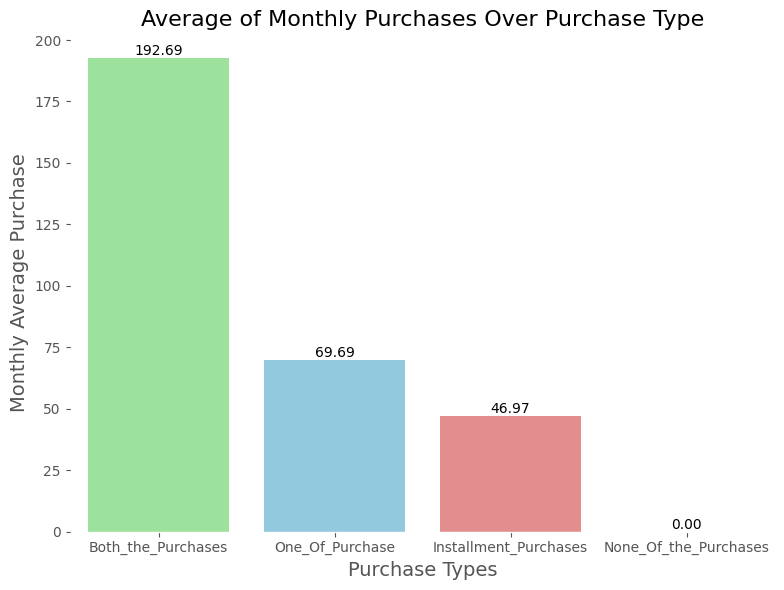

In [40]:
color_mapping = {
    'None_Of_the_Purchases': 'mediumpurple',
    'One_Of_Purchase': 'skyblue',
    'Installment_Purchases': 'lightcoral',
    'Both_the_Purchases': 'lightgreen'
}

colors = [color_mapping[purchase_type] for purchase_type in monthly_avg_purchases_PT.index]

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

sns.barplot(x=monthly_avg_purchases_PT.index, 
            y=monthly_avg_purchases_PT.values, 
            palette=colors, 
            ax=ax)

ax.set_title('Average of Monthly Purchases Over Purchase Type', fontsize=16)
ax.set_xlabel('Purchase Types', fontsize=14)
ax.set_ylabel('Monthly Average Purchase', fontsize=14)
ax.set_xticklabels(monthly_avg_purchases_PT.index, rotation=0)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [41]:
df.groupby(by=['Purchase_Type'])['MONTHLY_AVG_PURCHASES'].describe()

count        mean         std       min        25%  \
Purchase_Type                                                                
Both_the_Purchases     2774.0  192.685172  268.042019  3.319167  58.213125   
Installment_Purchases  2260.0   46.974347   74.327572  0.000000  13.827292   
None_Of_the_Purchases  2041.0    0.000000    0.000000  0.000000   0.000000   
One_Of_Purchase        1874.0   69.688958  124.993886  0.000833  11.546250   

                              50%         75%          max  
Purchase_Type                                               
Both_the_Purchases     120.523750  229.396042  4086.630833  
Installment_Purchases   29.132083   53.647273  1875.000000  
None_Of_the_Purchases    0.000000    0.000000     0.000000  
One_Of_Purchase         32.444167   82.074640  1841.815000

#### Insights:

- **Highest Average Purchase Amount**:  
  Customers who made both one-off and installment purchases have achieved the highest total average purchase amount over the last 12 months, with an average of **$192.69**. This suggests a strong purchasing behavior and possibly a higher engagement with the credit system.

- **Engagement and Spending Patterns**:  
  The high average for customers making both purchase types suggests a strong engagement with their credit, reflecting positive financial behavior. The installment purchases, while lower in average, still indicate a responsible approach to spending, as evidenced by the significantly lower standard deviation.

- **Credit Usage Insight**:  
  Understanding these purchasing behaviors can inform strategies for credit offers and customer engagement, focusing on the different spending patterns of customers based on their purchase types.

IV) Monthly Cash Advance per Purchase Type

In [42]:
monthly_cash_advance_PT = df.groupby(['Purchase_Type'])['AVG_CASH_ADVANCE'].mean().sort_values(ascending=False).reset_index()
monthly_cash_advance_PT

Purchase_Type  AVG_CASH_ADVANCE
0  None_Of_the_Purchases        182.932504
1        One_Of_Purchase         78.995966
2     Both_the_Purchases         67.821985
3  Installment_Purchases         38.398206

In [43]:
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'MONTHLY_AVG_PURCHASES', 'AVG_CASH_ADVANCE', 'Purchase_Type',
       'Limit_Usage', 'Pay_to_MinimumPay'],
      dtype='object')

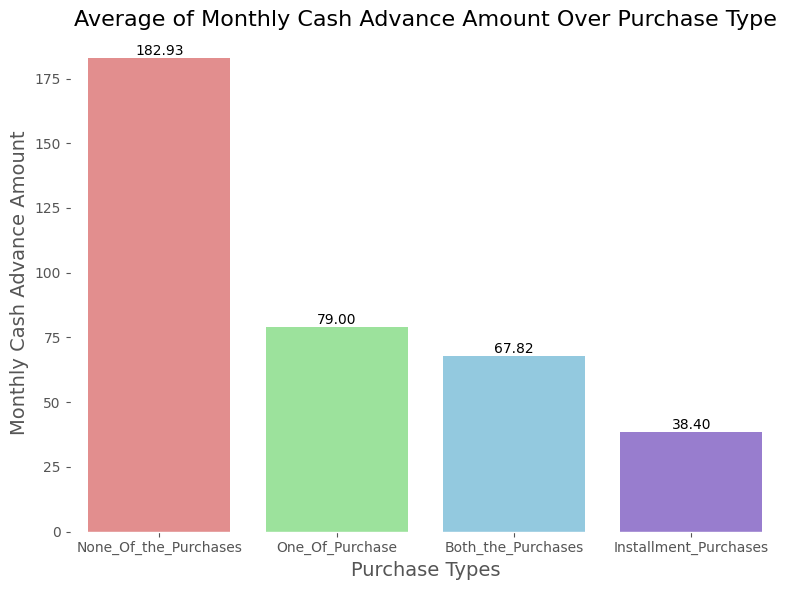

In [44]:
color_mapping = {
    'None_Of_the_Purchases': 'mediumpurple',
    'One_Of_Purchase': 'skyblue',
    'Installment_Purchases': 'lightcoral',
    'Both_the_Purchases': 'lightgreen'
}

colors = [color_mapping[purchase_type] for purchase_type in balance_credit_limit_PT['Purchase_Type']]

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')


sns.barplot(x=monthly_cash_advance_PT['Purchase_Type'], 
            y=monthly_cash_advance_PT['AVG_CASH_ADVANCE'], 
            palette=colors, 
            ax=ax)

ax.set_title('Average of Monthly Cash Advance Amount Over Purchase Type', fontsize=16)
ax.set_xlabel('Purchase Types', fontsize=14)
ax.set_ylabel('Monthly Cash Advance Amount', fontsize=14)
ax.set_xticklabels(monthly_cash_advance_PT['Purchase_Type'], rotation=0)


for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [45]:
df.groupby(['Purchase_Type'])['AVG_CASH_ADVANCE'].describe()

count        mean         std  min        25%  \
Purchase_Type                                                           
Both_the_Purchases     2774.0   67.821985  191.611168  0.0   0.000000   
Installment_Purchases  2260.0   38.398206  132.687018  0.0   0.000000   
None_Of_the_Purchases  2041.0  182.932504  231.821865  0.0  32.977134   
One_Of_Purchase        1874.0   78.995966  175.009907  0.0   0.000000   

                              50%         75%          max  
Purchase_Type                                               
Both_the_Purchases       0.000000   47.461748  3928.100980  
Installment_Purchases    0.000000    0.000000  2132.398656  
None_Of_the_Purchases  108.730274  242.944955  2381.277231  
One_Of_Purchase          0.000000   77.100742  1689.777593

#### Insights:

- **Highest Average Purchase Amount**:  
  Customers who made both one-off and installment purchases have achieved the highest total average purchase amount over the last 12 months, with an average of **$192.69**. This suggests a strong purchasing behavior and possibly a higher engagement with the credit system.

- **Engagement and Spending Patterns**:  
  The high average for customers making both purchase types suggests a strong engagement with their credit, reflecting positive financial behavior. The installment purchases, while lower in average, still indicate a responsible approach to spending, as evidenced by the significantly lower standard deviation.

- **Credit Usage Insight**:  
  Understanding these purchasing behaviors can inform strategies for credit offers and customer engagement, focusing on the different spending patterns of customers based on their purchase types.

## 3.4 Investigating correlations to find relationships between features

To reduce redundancy in the dataset, we will drop the original variables: **'BALANCE'**, **'PURCHASES'**, **'PAYMENTS'**, **'MINIMUM_PAYMENTS'**, **'TENURE'**, and **'CASH_ADVANCE'**. These variables have been utilized to create new derived variables, referred to as KPIs, and may introduce correlations that can complicate analysis. Removing them will streamline the dataset and improve the clarity of our insights.



In [46]:
df_num = df.drop(['BALANCE', 'CREDIT_LIMIT', 'PURCHASES', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'TENURE', 'CASH_ADVANCE', 'Purchase_Type'], axis=1)

In [47]:
df_num.columns

Index(['BALANCE_FREQUENCY', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'PRC_FULL_PAYMENT',
       'MONTHLY_AVG_PURCHASES', 'AVG_CASH_ADVANCE', 'Limit_Usage',
       'Pay_to_MinimumPay'],
      dtype='object')

In [48]:
df_num.head()

BALANCE_FREQUENCY  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  \
0           0.818182              0.00                    95.4   
1           0.909091              0.00                     0.0   
2           1.000000            773.17                     0.0   
3           0.636364           1499.00                     0.0   
4           1.000000             16.00                     0.0   

   PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
0             0.166667                    0.000000   
1             0.000000                    0.000000   
2             1.000000                    1.000000   
3             0.083333                    0.083333   
4             0.083333                    0.083333   

   PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  \
0                          0.083333                0.000000                 0   
1                          0.000000                0.250000                 4   
2                          0.000000                0.000000                 0   
3                          0.000000                0.083333                 1   
4                          0.000000                0.000000                 0   

   PURCHASES_TRX  PRC_FULL_PAYMENT  MONTHLY_AVG_PURCHASES  AVG_CASH_ADVANCE  \
0              2          0.000000               7.950000          0.000000   
1              0          0.222222               0.000000        536.912124   
2             12          0.000000              64.430833          0.000000   
3              1          0.000000             124.916667         17.149001   
4              1          0.000000               1.333333          0.000000   

   Limit_Usage  Pay_to_MinimumPay  
0     0.040901           1.446508  
1     0.457495           3.826241  
2     0.332687           0.991682  
3     0.222223           0.000000  
4     0.681429           2.771075

In [49]:
corr_matrix = df_num.corr()
corr_matrix

BALANCE_FREQUENCY  ONEOFF_PURCHASES  \
BALANCE_FREQUENCY                          1.000000          0.104257   
ONEOFF_PURCHASES                           0.104257          1.000000   
INSTALLMENTS_PURCHASES                     0.124204          0.330610   
PURCHASES_FREQUENCY                        0.229440          0.264913   
ONEOFF_PURCHASES_FREQUENCY                 0.202295          0.524881   
PURCHASES_INSTALLMENTS_FREQUENCY           0.175869          0.127699   
CASH_ADVANCE_FREQUENCY                     0.192022         -0.082622   
CASH_ADVANCE_TRX                           0.141516         -0.046226   
PURCHASES_TRX                              0.189527          0.545514   
PRC_FULL_PAYMENT                          -0.095308          0.132745   
MONTHLY_AVG_PURCHASES                      0.131188          0.913059   
AVG_CASH_ADVANCE                           0.085963         -0.034557   
Limit_Usage                                0.404557         -0.042254   
Pay_to_MinimumPay                         -0.089340          0.010298   

                                  INSTALLMENTS_PURCHASES  PURCHASES_FREQUENCY  \
BALANCE_FREQUENCY                               0.124204             0.229440   
ONEOFF_PURCHASES                                0.330610             0.264913   
INSTALLMENTS_PURCHASES                          1.000000             0.442398   
PURCHASES_FREQUENCY                             0.442398             1.000000   
ONEOFF_PURCHASES_FREQUENCY                      0.214016             0.501305   
PURCHASES_INSTALLMENTS_FREQUENCY                0.511334             0.862921   
CASH_ADVANCE_FREQUENCY                         -0.132312            -0.308483   
CASH_ADVANCE_TRX                               -0.074017            -0.203541   
PURCHASES_TRX                                   0.628097             0.568408   
PRC_FULL_PAYMENT                                0.182548             0.305761   
MONTHLY_AVG_PURCHASES                           0.677016             0.395310   
AVG_CASH_ADVANCE                               -0.067799            -0.215846   
Limit_Usage                                    -0.058318            -0.201944   
Pay_to_MinimumPay                               0.020618             0.011399   

                                  ONEOFF_PURCHASES_FREQUENCY  \
BALANCE_FREQUENCY                                   0.202295   
ONEOFF_PURCHASES                                    0.524881   
INSTALLMENTS_PURCHASES                              0.214016   
PURCHASES_FREQUENCY                                 0.501305   
ONEOFF_PURCHASES_FREQUENCY                          1.000000   
PURCHASES_INSTALLMENTS_FREQUENCY                    0.142270   
CASH_ADVANCE_FREQUENCY                             -0.111707   
CASH_ADVANCE_TRX                                   -0.069116   
PURCHASES_TRX                                       0.544849   
PRC_FULL_PAYMENT                                    0.157497   
MONTHLY_AVG_PURCHASES                               0.499694   
AVG_CASH_ADVANCE                                   -0.089059   
Limit_Usage                                        -0.092089   
Pay_to_MinimumPay                                  -0.004556   

                                  PURCHASES_INSTALLMENTS_FREQUENCY  \
BALANCE_FREQUENCY                                         0.175869   
ONEOFF_PURCHASES                                          0.127699   
INSTALLMENTS_PURCHASES                                    0.511334   
PURCHASES_FREQUENCY                                       0.862921   
ONEOFF_PURCHASES_FREQUENCY                                0.142270   
PURCHASES_INSTALLMENTS_FREQUENCY                          1.000000   
CASH_ADVANCE_FREQUENCY                                   -0.262955   
CASH_ADVANCE_TRX                                         -0.169250   
PURCHASES_TRX                                             0.529949   
PRC_FULL_PAYMENT                                          0.2

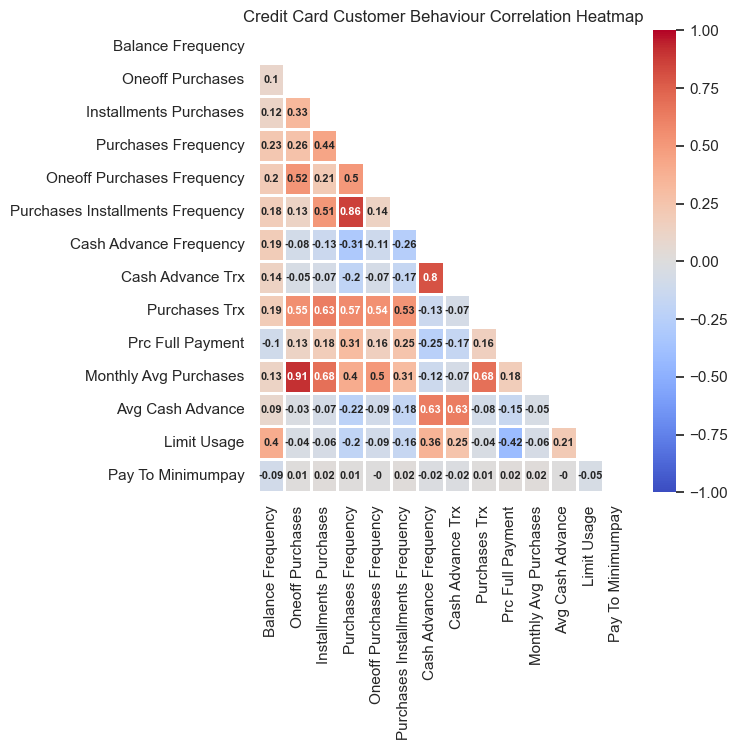

In [50]:
corrMat(df_num)

##### Insights: 

A correlation value above 0.50 is considered highly correlated. From the heatmap, we can observe the following:

1. **ONEOFF_PURCHASES** is highly positively correlated with **MONTHLY_AVG_PURCHASES** with a correlation of **0.91**.
2. **INSTALLMENTS_PURCHASES** is correlated with **PURCHASES_TRX**, showing a correlation of **0.63**, and with **MONTHLY_AVG_PURCHASES**, having a correlation of **0.68**.
3. **PURCHASES_FREQUENCY** is positively correlated with **PURCHASES_INSTALLMENTS_FREQUENCY**, showing a correlation of **0.86**, and also with **PURCHASES_TRX**, which has a correlation of **0.57**.
4. **CASH_ADVANCE_FREQUENCY** is highly positively correlated with **CASH_ADVANCE_TRX**, with a correlation of **0.80**, and with **AVG_CASH_ADVANCE**, which has a correlation of **0.63**.
5. **CASH_ADVANCE_TRX** is also positively correlated with **AVG_CASH_ADVANCE**, with a correlation of **0.63**.
6. **PURCHASES_TRX** is positively correlated with **MONTHLY_AVG_PURCHASES**, showing a correlation of **0.68**.

This indicates the presence of multicollinearity in the data, suggesting the need to utilize dimension reduction techniques, as redundant information is being fed into the model.


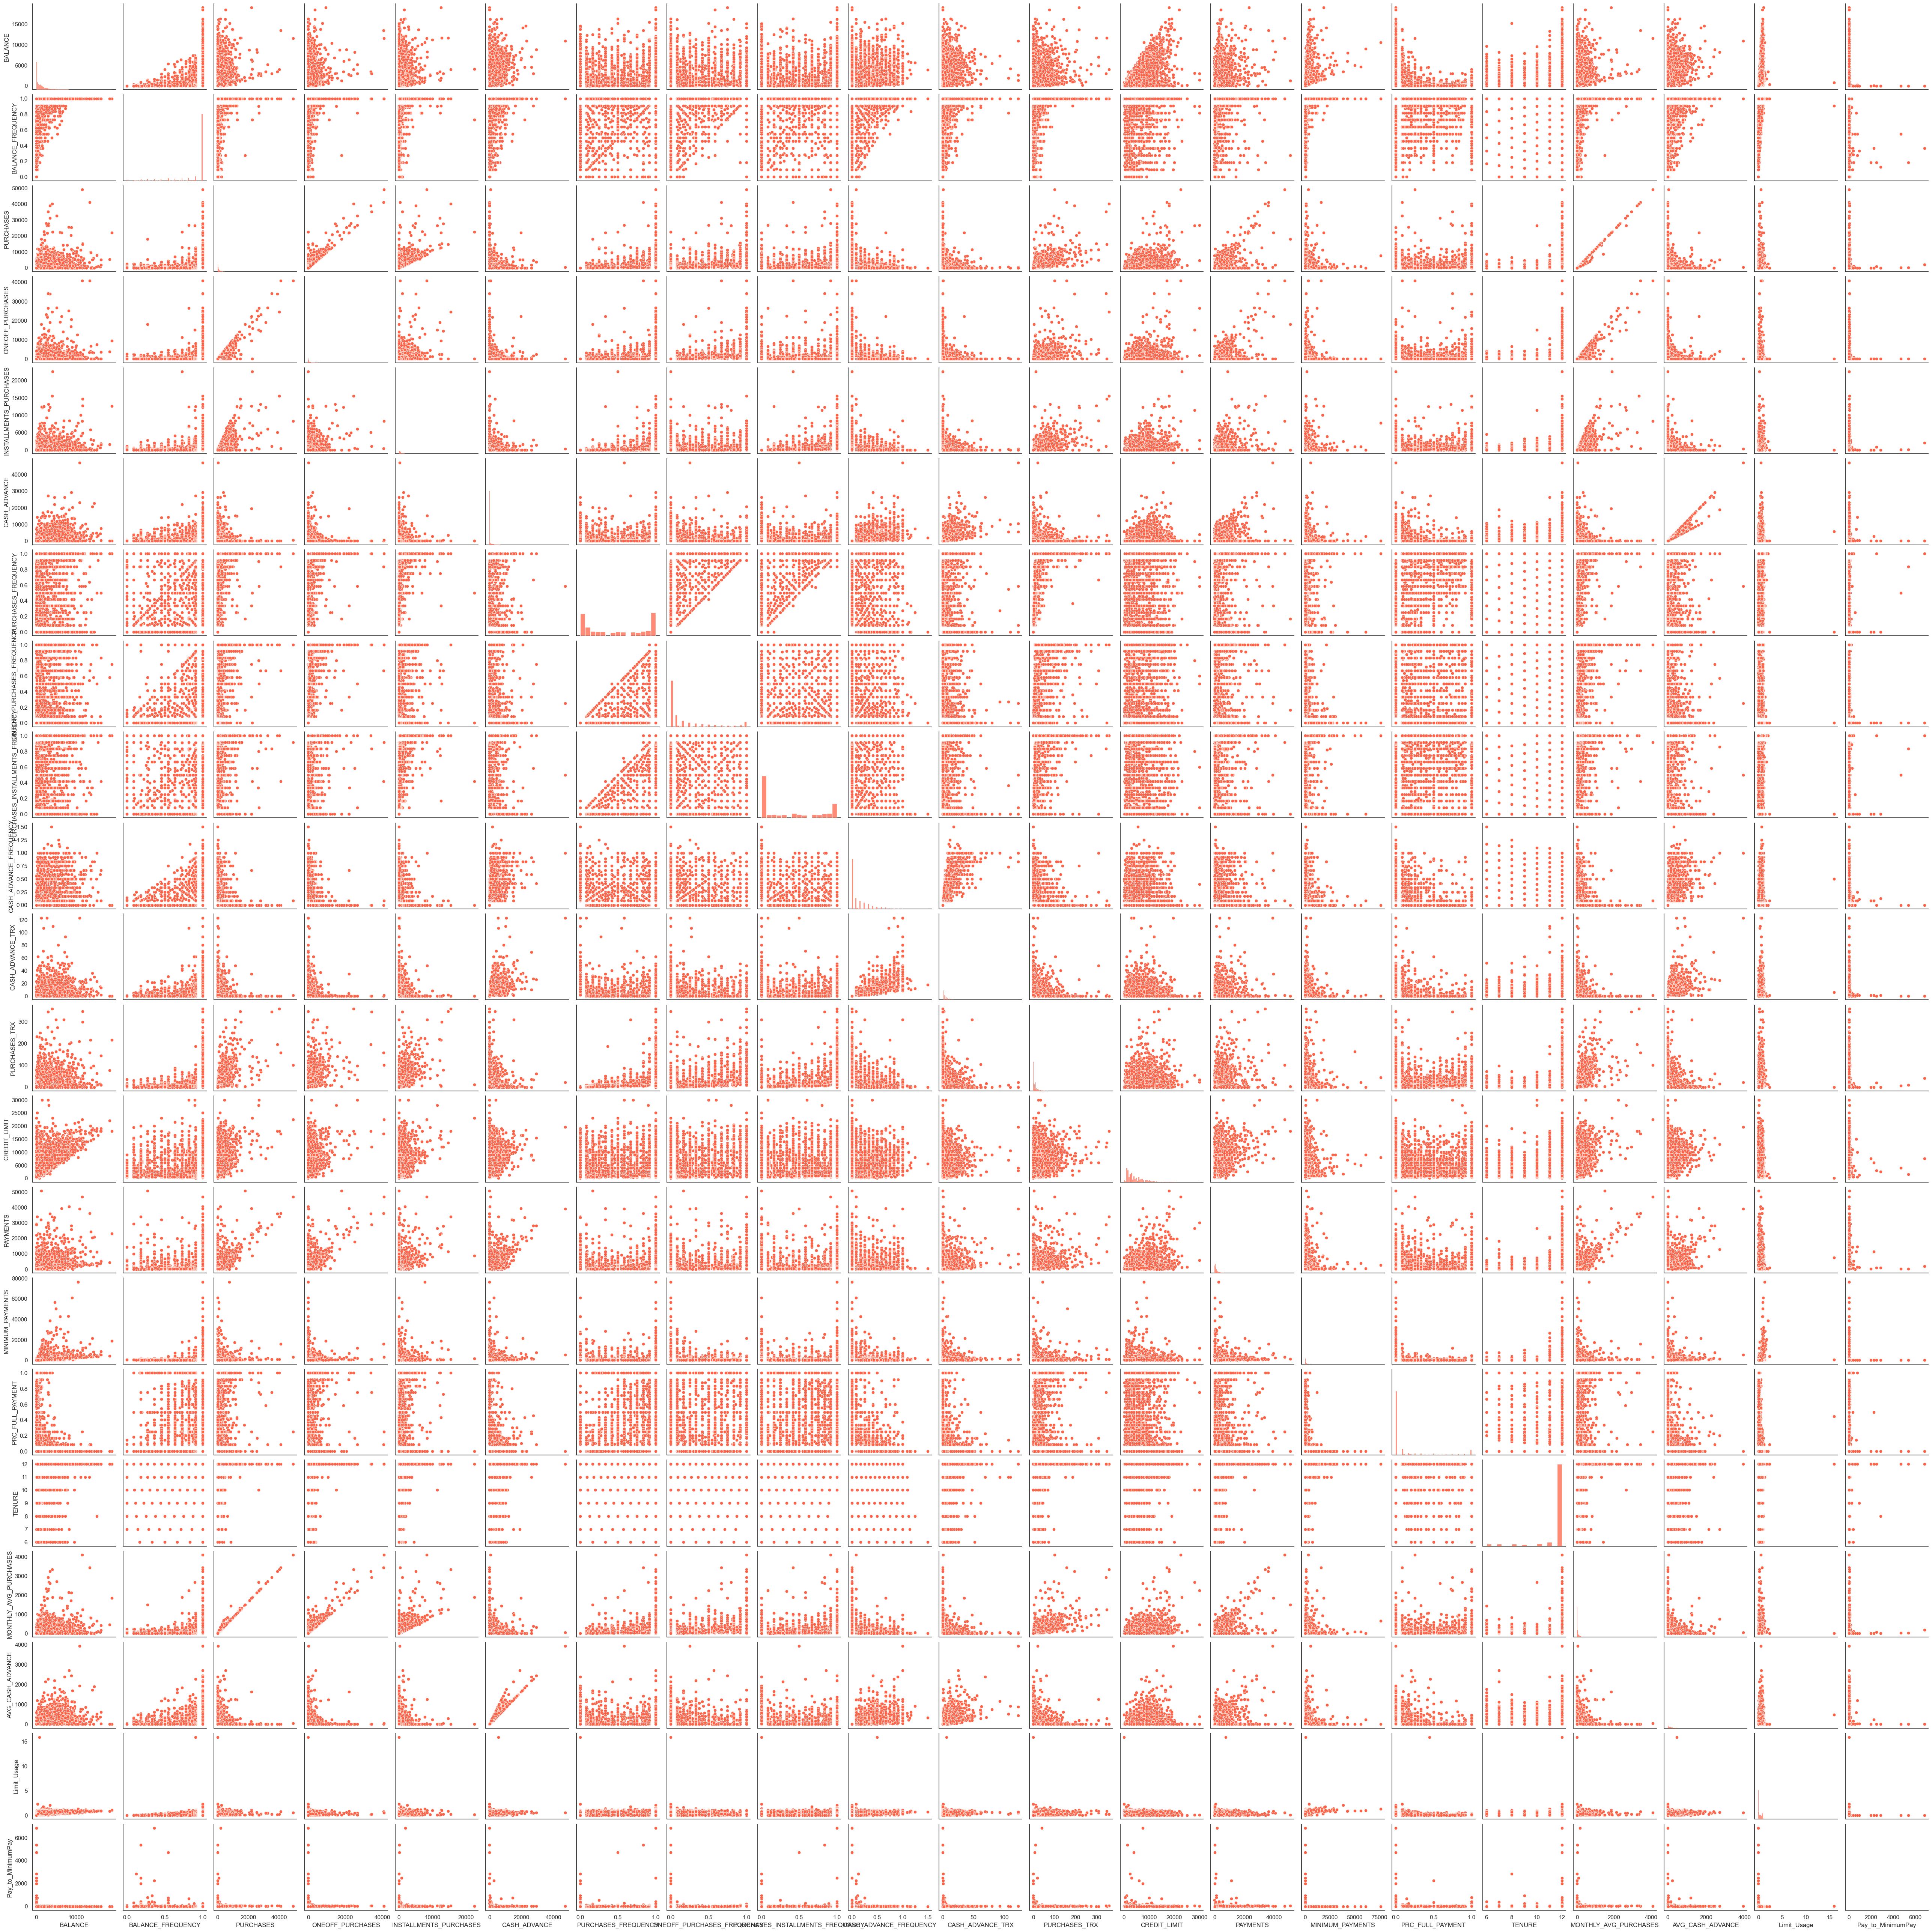

In [49]:
sns.pairplot(df, 
             diag_kws={'color': 'tomato'}, 
             plot_kws={'color': 'tomato'})
plt.show()

Through the readability of the pairplot is kind of difficult, we can observe some linear and nonlinear relationships between variables.


## 3.4. Feature preparing for Modeling 

Here we will create dummy variables for Purchase_Type, and insert into our new dataframe with the KPI's

In [51]:
df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  ...  CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  \
0                0.000000  ...        1000.0   201.802084        139.509787   
1                0.250000  ...        7000.0  4103.032597       1072.340217   
2                0.000000  ...        7500.0   622.066742        627.284787   
3                0.083333  ...        7500.0     0.000000        312.452292   
4                0.000000  ...        1200.0   678.334763        244.791237   

   PRC_FULL_PAYMENT  TENURE  MONTHLY_AVG_PURCHASES  AVG_CASH_ADVANCE  \
0          0.000000      12               7.950000          0.000000   
1          0.222222      12               0.000000        536.912124   
2          0.000000      12              64.430833          0.000000   
3          0.000000      12             124.916667         17.149001   
4          0.000000      12               1.333333          0.000000   

           Purchase_Type  Limit_Usage Pay_to_MinimumPay  
0  Installment_Purchases     0.040901          1.446508  
1  None_Of_the_Purchases     0.457495          3.826241  
2        One_Of_Purchase     0.332687          0.991682  
3        One_Of_Purchase     0.222223          0.000000  
4        One_Of_Purchase     0.681429          2.771075  

[5 rows x 22 columns]

In [52]:
cat_vars = pd.get_dummies(df['Purchase_Type'], drop_first=True).astype(int)
cat_vars

Installment_Purchases  None_Of_the_Purchases  One_Of_Purchase
0                         1                      0                0
1                         0                      1                0
2                         0                      0                1
3                         0                      0                1
4                         0                      0                1
...                     ...                    ...              ...
8944                      1                      0                0
8945                      1                      0                0
8946                      1                      0                0
8947                      0                      1                0
8948                      0                      0                1

[8949 rows x 3 columns]

In [53]:
num_vars_KPI = df.dtypes[df.dtypes != 'object'].index.to_list()
num_vars_KPI

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE',
 'MONTHLY_AVG_PURCHASES',
 'AVG_CASH_ADVANCE',
 'Limit_Usage',
 'Pay_to_MinimumPay']

In [54]:
df1 = df.copy()
num_vars_original = df1.dtypes[df1.dtypes != 'object'].index.to_list()
num_vars_original

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE',
 'MONTHLY_AVG_PURCHASES',
 'AVG_CASH_ADVANCE',
 'Limit_Usage',
 'Pay_to_MinimumPay']

We can reconstruct the original date (without Scaling) and add the dummy variables to create the new dataframe.

In [55]:
num_vars_original_dummies = pd.concat([cat_vars, df1[num_vars_original]], axis = 1)
num_vars_original_dummies.head()

Installment_Purchases  None_Of_the_Purchases  One_Of_Purchase      BALANCE  \
0                      1                      0                0    40.900749   
1                      0                      1                0  3202.467416   
2                      0                      0                1  2495.148862   
3                      0                      0                1  1666.670542   
4                      0                      0                1   817.714335   

   BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  \
0           0.818182      95.40              0.00                    95.4   
1           0.909091       0.00              0.00                     0.0   
2           1.000000     773.17            773.17                     0.0   
3           0.636364    1499.00           1499.00                     0.0   
4           1.000000      16.00             16.00                     0.0   

   CASH_ADVANCE  PURCHASES_FREQUENCY  ...  PURCHASES_TRX  CREDIT_LIMIT  \
0      0.000000             0.166667  ...              2        1000.0   
1   6442.945483             0.000000  ...              0        7000.0   
2      0.000000             1.000000  ...             12        7500.0   
3    205.788017             0.083333  ...              1        7500.0   
4      0.000000             0.083333  ...              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  \
0   201.802084        139.509787          0.000000      12   
1  4103.032597       1072.340217          0.222222      12   
2   622.066742        627.284787          0.000000      12   
3     0.000000        312.452292          0.000000      12   
4   678.334763        244.791237          0.000000      12   

   MONTHLY_AVG_PURCHASES  AVG_CASH_ADVANCE  Limit_Usage  Pay_to_MinimumPay  
0               7.950000          0.000000     0.040901           1.446508  
1               0.000000        536.912124     0.457495           3.826241  
2              64.430833          0.000000     0.332687           0.991682  
3             124.916667         17.149001     0.222223           0.000000  
4               1.333333          0.000000     0.681429           2.771075  

[5 rows x 24 columns]

In [56]:
save_path = '../results/EDA_results'

# Create directory if it does not exist
if not os.path.exists(save_path):
    os.makedirs(save_path, exist_ok=True)

# Save the dataframe to CSV inside the EDA_results folder
num_vars_original_dummies.to_csv(os.path.join(save_path, 'original_df_DM.csv'), index=False)

### 3.4.1. Feature Scaling

In [57]:
from sklearn.preprocessing import StandardScaler 

In [58]:
SS = StandardScaler()

X_scaled = pd.DataFrame(SS.fit_transform(df[num_vars_KPI]), columns=num_vars_KPI)
X_scaled.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.732054          -0.249881  -0.424934         -0.356957   
1  0.786858           0.134049  -0.469584         -0.356957   
2  0.447041           0.517980  -0.107716          0.108843   
3  0.049015          -1.017743   0.231995          0.546123   
4 -0.358849           0.517980  -0.462095         -0.347317   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349114     -0.466805            -0.806649   
1               -0.454607      2.605438            -1.221928   
2               -0.454607     -0.466805             1.269742   
3               -0.454607     -0.368678            -1.014290   
4               -0.454607     -0.466805            -1.014290   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678716                         -0.707409   
1                   -0.678716                         -0.917090   
2                    2.673295                         -0.917090   
3                   -0.399383                         -0.917090   
4                   -0.399383                         -0.917090   

   CASH_ADVANCE_FREQUENCY  ...  PURCHASES_TRX  CREDIT_LIMIT  PAYMENTS  \
0               -0.675294  ...      -0.511381     -0.960380 -0.529026   
1                0.573949  ...      -0.591841      0.688601  0.818546   
2               -0.675294  ...      -0.109082      0.826016 -0.383857   
3               -0.258882  ...      -0.551611      0.826016 -0.598733   
4               -0.675294  ...      -0.551611     -0.905414 -0.364421   

   MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  MONTHLY_AVG_PURCHASES  \
0         -0.302427         -0.525588  0.360541              -0.433418   
1          0.097453          0.234159  0.360541              -0.477461   
2         -0.093330         -0.525588  0.360541              -0.120516   
3         -0.228291         -0.525588  0.360541               0.214573   
4         -0.257295         -0.525588  0.360541              -0.470074   

   AVG_CASH_ADVANCE  Limit_Usage  Pay_to_MinimumPay  
0         -0.460737    -0.893059          -0.064423  
1          2.319245     0.175953          -0.044287  
2         -0.460737    -0.144316          -0.068272  
3         -0.371944    -0.427774          -0.076663  
4         -0.460737     0.750582          -0.053215  

[5 rows x 21 columns]

In [59]:
X_scaled.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'MONTHLY_AVG_PURCHASES', 'AVG_CASH_ADVANCE', 'Limit_Usage',
       'Pay_to_MinimumPay'],
      dtype='object')

In [60]:
full_df = pd.concat([cat_vars, X_scaled], axis = 1)
full_df.head()


Installment_Purchases  None_Of_the_Purchases  One_Of_Purchase   BALANCE  \
0                      1                      0                0 -0.732054   
1                      0                      1                0  0.786858   
2                      0                      0                1  0.447041   
3                      0                      0                1  0.049015   
4                      0                      0                1 -0.358849   

   BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  \
0          -0.249881  -0.424934         -0.356957               -0.349114   
1           0.134049  -0.469584         -0.356957               -0.454607   
2           0.517980  -0.107716          0.108843               -0.454607   
3          -1.017743   0.231995          0.546123               -0.454607   
4           0.517980  -0.462095         -0.347317               -0.454607   

   CASH_ADVANCE  PURCHASES_FREQUENCY  ...  PURCHASES_TRX  CREDIT_LIMIT  \
0     -0.466805            -0.806649  ...      -0.511381     -0.960380   
1      2.605438            -1.221928  ...      -0.591841      0.688601   
2     -0.466805             1.269742  ...      -0.109082      0.826016   
3     -0.368678            -1.014290  ...      -0.551611      0.826016   
4     -0.466805            -1.014290  ...      -0.551611     -0.905414   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  \
0 -0.529026         -0.302427         -0.525588  0.360541   
1  0.818546          0.097453          0.234159  0.360541   
2 -0.383857         -0.093330         -0.525588  0.360541   
3 -0.598733         -0.228291         -0.525588  0.360541   
4 -0.364421         -0.257295         -0.525588  0.360541   

   MONTHLY_AVG_PURCHASES  AVG_CASH_ADVANCE  Limit_Usage  Pay_to_MinimumPay  
0              -0.433418         -0.460737    -0.893059          -0.064423  
1              -0.477461          2.319245     0.175953          -0.044287  
2              -0.120516         -0.460737    -0.144316          -0.068272  
3               0.214573         -0.371944    -0.427774          -0.076663  
4              -0.470074         -0.460737     0.750582          -0.053215  

[5 rows x 24 columns]

In [61]:
save_path = '../results/EDA_results'

# Create directory if it does not exist
if not os.path.exists(save_path):
    os.makedirs(save_path, exist_ok=True)

# Save the dataframe to CSV inside the EDA_results folder
full_df.to_csv(os.path.join(save_path, 'full_df.csv'), index=False)

In [62]:
full_df.columns

Index(['Installment_Purchases', 'None_Of_the_Purchases', 'One_Of_Purchase',
       'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'MONTHLY_AVG_PURCHASES', 'AVG_CASH_ADVANCE', 'Limit_Usage',
       'Pay_to_MinimumPay'],
      dtype='object')

### 3.4.2. Reducing dimensionality through Principal Component Analysis (PCA)

Since, as described above our correlation heatplot showed some high colinearity between some of the numer, will we perform and Principal Component Analysis (PCA) to reduce the dimensionality of our full dataset. 

In [63]:
cov_matrix = np.cov(full_df.T)
print(cov_matrix.shape)

(24, 24)


In [64]:
print('Covariance Matrix: ', cov_matrix)

Covariance Matrix:  [[ 1.88785725e-01 -5.76037770e-02 -5.28904841e-02 -8.72900423e-02
  -5.85588264e-02 -5.51350668e-02 -9.01566497e-02  3.54042685e-02
  -6.73233653e-02  1.28560823e-01 -1.71423624e-01  1.86840202e-01
  -1.03028898e-01 -7.34103231e-02 -2.85580526e-02 -7.79230511e-02
  -6.44850127e-02  5.12132819e-05  8.57455742e-02 -9.07162899e-03
  -5.48645138e-02 -6.61536110e-02 -7.59902074e-02  8.97371869e-03]
 [-5.76037770e-02  1.76073846e-01 -4.77652558e-02  6.40141446e-02
   5.18779155e-03 -1.07110052e-01 -8.14202310e-02 -1.03693857e-01
   1.09894855e-01 -2.78623711e-01 -1.54812220e-01 -2.09090408e-01
   1.56841126e-01  1.02046533e-01 -1.34982769e-01 -2.93352094e-02
  -6.21197263e-03  1.30852183e-02 -8.52685765e-02 -3.36931689e-02
  -1.08906777e-01  1.10954142e-01  1.08354072e-01  1.99179805e-03]
 [-5.28904841e-02 -4.77652558e-02  1.65575299e-01 -1.26663458e-02
  -3.62807457e-02 -2.12272001e-02  2.45185407e-02 -9.52093525e-02
  -1.08283237e-02 -8.84012481e-02  8.30477924e-02 -1.9

Calculating eigenvalues and eingenvectors for PCA

In [65]:
eig_values, eig_vectors = np.linalg.eig(cov_matrix)
print(len(eig_values))
print(eig_vectors.shape)

24
(24, 24)


In [66]:
print('Eigen Vectors:', eig_vectors)
print('Eigen Values:', eig_values)

Eigen Vectors: [[ 6.42658884e-03 -6.65585835e-02 -3.47606485e-02  1.52637881e-01
   1.07106699e-01  9.38733238e-02 -5.49763279e-02  4.28974662e-02
   5.41918450e-03 -3.62752560e-02  5.99018724e-02 -1.95104212e-01
   8.25159041e-02  5.27110091e-03 -6.50650311e-02  1.83910374e-01
  -1.94708435e-01  2.96649782e-04 -8.36664859e-01 -1.70849395e-02
  -3.46051135e-01  4.46903198e-03  3.51603868e-04  4.16627675e-04]
 [ 7.78237211e-02  6.89171318e-02  2.91092372e-02 -7.99059433e-02
   1.25966759e-02  5.67270049e-02 -1.02577685e-02  7.19347372e-02
  -2.26520161e-02 -1.10465734e-01 -7.37204168e-02  7.12263986e-02
  -3.03820518e-02  1.86808145e-01  1.71328537e-01 -3.47708030e-01
   4.11818685e-01 -1.29828586e-02 -5.63870901e-03  5.60308694e-01
  -5.28760317e-01  1.64364431e-02 -9.42540863e-05  2.02063561e-02]
 [ 2.15037922e-02  2.15081299e-03  5.60809924e-02 -1.23007857e-01
  -5.81334738e-02 -7.77366673e-02  2.23119544e-02 -8.06525219e-02
  -4.02807798e-02  7.37897090e-02  1.88183375e-02  7.812215

In [67]:
explained_var = eig_values / np.sum(eig_values)
explained_var = np.sort(explained_var)[::-1]

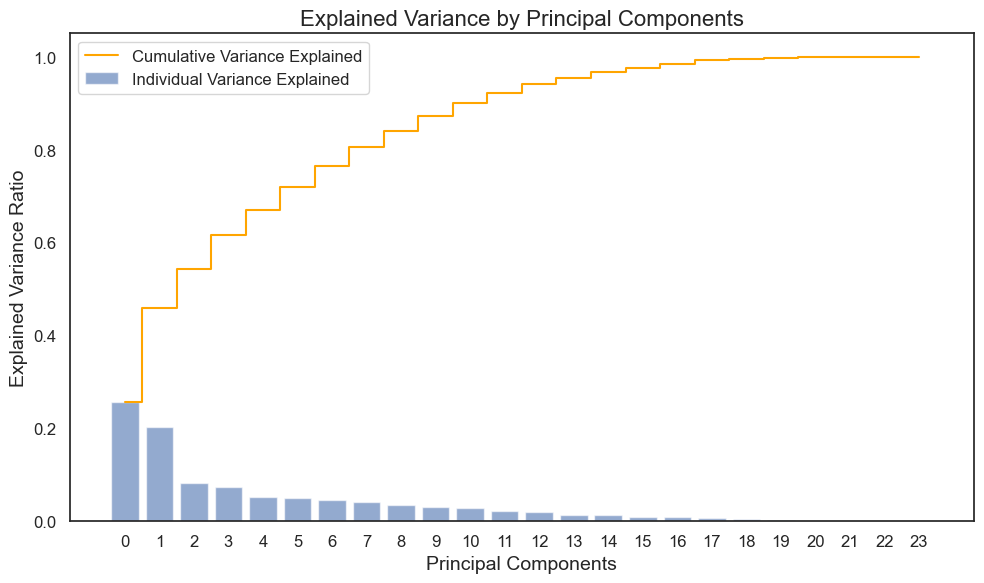

In [68]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_var)), explained_var, alpha=0.6, align='center', label='Individual Variance Explained')
plt.step(range(len(explained_var)), np.cumsum(explained_var), where='mid', label='Cumulative Variance Explained', color='orange')

plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.xlabel('Principal Components', fontsize=14)
plt.xticks(range(len(explained_var)), fontsize=12)
plt.yticks(fontsize=12)
plt.title('Explained Variance by Principal Components', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'explained_variance.png'))
plt.show()

#### 3.4.3. PCA Analysis through sklearn


In [69]:
from sklearn.decomposition import PCA

In [70]:
pca_model = PCA(n_components = 17)
X_PCA = pca_model.fit_transform(full_df)

In [71]:
X_PCA.shape

(8949, 17)

In [72]:
pca_var = pca_model.explained_variance_ratio_
np.cumsum(pca_var)

array([0.25598511, 0.45953819, 0.54279444, 0.61670768, 0.66921352,
       0.71995904, 0.76539673, 0.80612161, 0.84046083, 0.8713881 ,
       0.899576  , 0.92137189, 0.94098511, 0.95495491, 0.9676131 ,
       0.97637674, 0.98469813])

In [73]:
eigen_summary_df = pd.DataFrame({
    'Eigen_Values': np.round(eig_values, 4),
    'Cumulative_Variance': np.round(np.cumsum(eig_values) / np.sum(eig_values) * 100, 4)
})

eigen_summary_df.index += 1  # Start index at 1 for better readability
eigen_summary_df.index.name = 'Principal Component'

In [74]:
eigen_summary_df

Eigen_Values  Cumulative_Variance
Principal Component                                   
1                          5.5121              25.5985
2                          4.3831              45.9538
3                          1.7927              54.2794
4                          1.5916              61.6708
5                          1.1306              66.9214
6                          1.0927              71.9959
7                          0.9784              76.5397
8                          0.8769              80.6122
9                          0.7394              84.0461
10                         0.6660              87.1388
11                         0.6070              89.9576
12                         0.4693              92.1372
13                         0.4223              94.0985
14                         0.3008              95.4955
15                         0.2726              96.7613
16                         0.1887              97.6377
17                         0.1538              98.3521
18                         0.1792              99.1843
19                         0.0888              99.5966
20                         0.0381              99.7738
21                         0.0281              99.9043
22                         0.0044              99.9247
23                         0.0000              99.9247
24                         0.0162             100.0000

### Explanation of the Decision

Our decision to retain seven principal components is based on a balance between maximizing explained variance and maintaining interpretability. Although all 17 components explain variance, focusing on a smaller subset allows us to simplify our analysis without losing significant information.

### Rationale for Retaining Seven Principal Components

1. **Variance Explained**: 
   - From both manual computation of PCA components and PCA via sklearn, we observe that all 17 components explain varying amounts of variance.
   - The first seven principal components cumulatively explain approximately **85%** of the total variance, with each individual component contributing more than **0.7** to the explained variance. This indicates that these components effectively capture the essential variability in the dataset.

2. **Diminishing Returns**:
   - Analyzing the eigenvalues reveals diminishing returns as we progress beyond the seventh component. The eighth component explains only a small increase in variance, with cumulative variance rising to approximately **80.61%**.
   - Retaining more components beyond the seventh introduces minimal additional explanatory power, making those components less meaningful for our analysis.

3. **Information Loss**:
   - By selecting seven dimensions out of the 17 variables, we are only losing about **15%** of the variation (information) from the data.
   - This slight reduction in explained variance is acceptable given the substantial amount of information retained for further analysis.

### Conclusion

In conclusion, selecting **seven principal components** provides a strong balance between capturing significant variance and maintaining interpretability. This decision aligns with data science best practices for dimensionality reduction, ensuring we retain crucial information while minimizing the risk of overfitting. These components will serve as a solid foundation for subsequent modeling and analysis.


In [75]:
#Selecting for 7 components
PCA_7 = PCA(n_components=7)
X_PCA_7 = PCA_7.fit_transform(full_df)

In [76]:
PC = pd.DataFrame(X_PCA_7, columns=['PC1 PC2 PC3 PC4 PC5 PC6 PC7'.split()])
PC

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0    -1.528694 -1.537251 -0.346265 -0.563789  0.336147 -0.144689 -0.170398
1    -1.523991  3.156023 -1.219119  0.450816  0.878437  0.570092 -0.405817
2     0.861720 -0.532769  0.532837 -0.975064 -0.915691  2.243882  0.685755
3    -0.610612 -0.351814 -1.033216 -1.665292  0.648527  0.437830 -0.234711
4    -1.610166 -0.745388  0.603639 -1.445444 -0.247502  0.032186  0.147155
...        ...       ...       ...       ...       ...       ...       ...
8944 -0.238034 -2.141524 -0.355087  2.294408 -1.828644 -2.385424 -0.433739
8945 -0.445795 -1.864212  0.147728  1.800713 -1.784116 -2.575422 -0.280652
8946 -0.790288 -2.024780 -0.605335  1.674297 -1.621808 -2.521633 -0.454524
8947 -2.186431 -0.996358 -1.563948 -0.041901 -1.891108 -2.544287 -0.450109
8948 -0.183294 -0.473391 -1.222562 -0.400017 -3.148680 -2.048420  0.292607

[8949 rows x 7 columns]

In [77]:
list_cols = full_df.columns

In [78]:
PC_with_all_variables = pd.DataFrame(PCA_7.components_.T, columns = ['PC_'+str(i) for i in range(1,8)], index = list_cols)
PC_with_all_variables

PC_1      PC_2      PC_3      PC_4  \
Installment_Purchases            -0.006427 -0.066559  0.034761  0.152638   
None_Of_the_Purchases            -0.077824  0.068917 -0.029109 -0.079906   
One_Of_Purchase                  -0.021504  0.002151 -0.056081 -0.123008   
BALANCE                           0.066138  0.359869  0.232462 -0.088486   
BALANCE_FREQUENCY                 0.087916  0.133598  0.453307  0.029895   
PURCHASES                         0.391841  0.058993 -0.099008 -0.192592   
ONEOFF_PURCHASES                  0.335682  0.071360 -0.171412 -0.317630   
INSTALLMENTS_PURCHASES            0.309711  0.008321  0.080742  0.128136   
CASH_ADVANCE                     -0.047834  0.406882 -0.163075  0.243678   
PURCHASES_FREQUENCY               0.283746 -0.138634  0.210284  0.400694   
ONEOFF_PURCHASES_FREQUENCY        0.265994  0.000036 -0.018657 -0.105766   
PURCHASES_INSTALLMENTS_FREQUENCY  0.239804 -0.128045  0.254144  0.492366   
CASH_ADVANCE_FREQUENCY           -0.101695  0.374076 -0.014688  0.119914   
CASH_ADVANCE_TRX                 -0.065105  0.360870 -0.060977  0.204709   
PURCHASES_TRX                     0.351317  0.010920  0.104042  0.067911   
CREDIT_LIMIT                      0.179803  0.199541 -0.130882  0.008643   
PAYMENTS                          0.238023  0.243512 -0.242551 -0.025193   
MINIMUM_PAYMENTS                  0.043439  0.150636  0.310189 -0.093321   
PRC_FULL_PAYMENT                  0.127045 -0.157955 -0.275256  0.284586   
TENURE                            0.065368 -0.016892  0.169578 -0.132937   
MONTHLY_AVG_PURCHASES             0.389976  0.059910 -0.104591 -0.185758   
AVG_CASH_ADVANCE                 -0.052865  0.399538 -0.176208  0.252644   
Limit_Usage                      -0.062295  0.229952  0.455875 -0.223367   
Pay_to_MinimumPay                 0.009497 -0.015305 -0.112026  0.036229   

                                      PC_5      PC_6      PC_7  
Installment_Purchases             0.107107 -0.093873 -0.054976  
None_Of_the_Purchases             0.012597 -0.056727 -0.010258  
One_Of_Purchase                  -0.058133  0.077737  0.022312  
BALANCE                           0.190971  0.101792 -0.030542  
BALANCE_FREQUENCY                -0.315702  0.200511  0.111584  
PURCHASES                        -0.034850 -0.165677 -0.028979  
ONEOFF_PURCHASES                 -0.152954 -0.062060  0.018897  
INSTALLMENTS_PURCHASES            0.198578 -0.277741 -0.103252  
CASH_ADVANCE                      0.039854  0.042581 -0.023037  
PURCHASES_FREQUENCY              -0.115630  0.100264  0.076986  
ONEOFF_PURCHASES_FREQUENCY       -0.367505  0.383564  0.194183  
PURCHASES_INSTALLMENTS_FREQUENCY  0.072185 -0.093549 -0.003835  
CASH_ADVANCE_FREQUENCY           -0.222554 -0.046315  0.083691  
CASH_ADVANCE_TRX                 -0.164331  0.003973  0.072515  
PURCHASES_TRX                    -0.058430 -0.029816  0.054309  
CREDIT_LIMIT                      0.306043  0.423577 -0.063217  
PAYMENTS                          0.137967 -0.049666 -0.054632  
MINIMUM_PAYMENTS                  0.410667 -0.209298 -0.181689  
PRC_FULL_PAYMENT                 -0.006612  0.102642 -0.129075  
TENURE                            0.408021  0.553536  0.066997  
MONTHLY_AVG_PURCHASES            -0.053658 -0.186207 -0.031359  
AVG_CASH_ADVANCE                 -0.009915 -0.020204 -0.029809  
Limit_Usage                      -0.120459 -0.206355  0.076770  
Pay_to_MinimumPay                 0.290300 -0.178440  0.918060

In [79]:
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC_{i+1}' for i in range(len(PCA_7.explained_variance_ratio_))],
    'Explained Variance (%)': PCA_7.explained_variance_ratio_ * 100
})

print(explained_variance_df)

  Principal Component  Explained Variance (%)
0                PC_1               25.598511
1                PC_2               20.355308
2                PC_3                8.325625
3                PC_4                7.391325
4                PC_5                5.250584
5                PC_6                5.074552
6                PC_7                4.543769


In [80]:

save_path = '../results/EDA_results'


if not os.path.exists(save_path):
    os.makedirs(save_path, exist_ok=True)


with open(os.path.join(save_path, 'X_PCA_7.pkl'), 'wb') as f:
    pickle.dump(X_PCA_7, f)

#### 3.4.3. Factor Analysis


We can use the factor loadings from our PCA to find out which of the features contribute more or less to each component.

In [81]:
loadings = pd.DataFrame(
    pca_model.components_.T * np.sqrt(pca_model.explained_variance_),
    index=list_cols,
    columns=[f'PC{i+1}' for i in range(17)]  
)

print(loadings)

                                       PC1       PC2       PC3       PC4  \
Installment_Purchases            -0.015088 -0.139346  0.046542  0.192563   
None_Of_the_Purchases            -0.182713  0.144283 -0.038975 -0.100807   
One_Of_Purchase                  -0.050486  0.004503 -0.075089 -0.155183   
BALANCE                           0.155278  0.753413  0.311251 -0.111632   
BALANCE_FREQUENCY                 0.206407  0.279698  0.606947  0.037715   
PURCHASES                         0.919957  0.123506 -0.132565 -0.242968   
ONEOFF_PURCHASES                  0.788107  0.149398 -0.229509 -0.400713   
INSTALLMENTS_PURCHASES            0.727133  0.017422  0.108108  0.161653   
CASH_ADVANCE                     -0.112304  0.851840 -0.218346  0.307417   
PURCHASES_FREQUENCY               0.666172 -0.290240  0.281556  0.505504   
ONEOFF_PURCHASES_FREQUENCY        0.624495  0.000075 -0.024980 -0.133431   
PURCHASES_INSTALLMENTS_FREQUENCY  0.563006 -0.268072  0.340281  0.621154   
CASH_ADVANCE

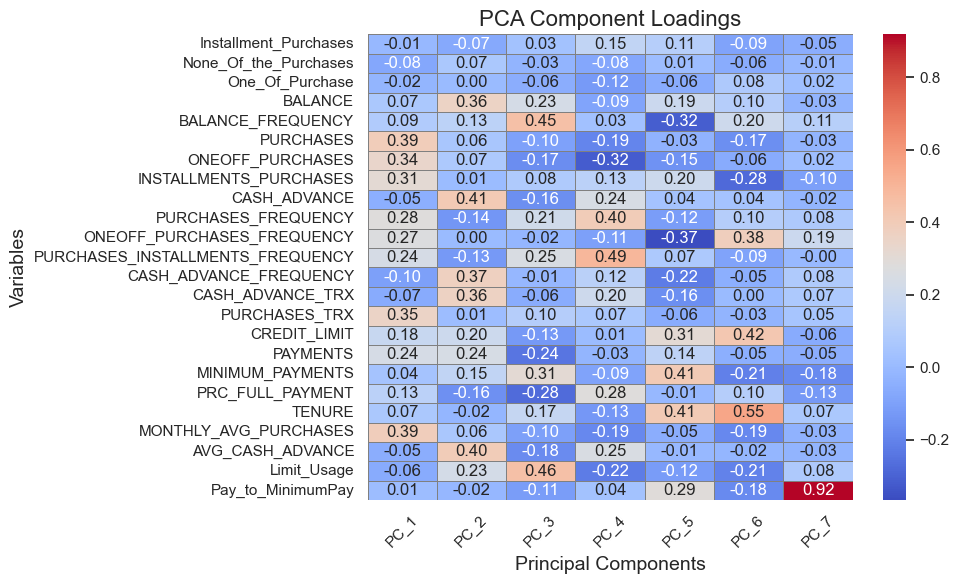

In [82]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

sns.heatmap(PC_with_all_variables, cmap='coolwarm', annot=True, fmt=".2f", cbar=True, 
            linewidths=.5, linecolor='gray', ax=ax)

ax.set_title('PCA Component Loadings', fontsize=16)
ax.set_xlabel('Principal Components', fontsize=14)
ax.set_ylabel('Variables', fontsize=14)
plt.xticks(rotation=45)
plt.savefig(os.path.join(save_path, 'PCA_loadings.png'))
plt.tight_layout()
plt.show()

#### Insights from Principal Component Loadings

1. **Principal Component 1 (PC_1)**:
   - **High Positive Loadings**: 
     - **PURCHASES (0.39)**: Indicates that higher purchases correlate positively with this component.
     - **ONEOFF_PURCHASES (0.34)**: Suggests that one-off purchases also contribute significantly.
   - **High Negative Loadings**:
     - **None significant** in this component.

2. **Principal Component 2 (PC_2)**:
   - **High Positive Loadings**:
     - **CASH_ADVANCE (0.41)**: Reflects a strong relationship between cash advances and this component.
     - **BALANCE_FREQUENCY (0.13)** and **CREDIT_LIMIT (0.20)** also have noteworthy contributions but are lower than other variables.
   - **High Negative Loadings**:
     - **PURCHASES_FREQUENCY (-0.14)**: Indicates that higher purchase frequency negatively affects this component.

3. **Principal Component 3 (PC_3)**:
   - **High Positive Loadings**:
     - **BALANCE_FREQUENCY (0.45)**: Indicates a strong relationship, suggesting that the frequency of balance impacts this component significantly.
     - **PURCHASES_INSTALLMENTS_FREQUENCY (0.25)** also indicates a notable influence but is less than the others.
   - **High Negative Loadings**:
     - **CREDIT_LIMIT (-0.13)**: Suggests that a higher credit limit inversely affects this component.

4. **Principal Component 4 (PC_4)**:
   - **High Positive Loadings**:
     - **PURCHASES_INSTALLMENTS_FREQUENCY (0.49)**: Indicates a significant positive impact.
     - **MINIMUM_PAYMENTS (0.31)** also suggests a strong relationship, highlighting its relevance to this component.
   - **High Negative Loadings**:
     - **ONEOFF_PURCHASES (-0.32)**: Indicates that one-off purchases negatively impact this component.

5. **Principal Component 6 (PC_6)**:
   - **High Positive Loadings**:
     - **CREDIT_LIMIT (0.42)**: Indicates a strong positive association, suggesting that higher credit limits are relevant to this component.
   - **High Negative Loadings**:
     - **INSTALLMENTS_PURCHASES (-0.28)**: Suggests an inverse relationship.

6. **Principal Component 7 (PC_7)**:
   - **High Positive Loadings**:
     - **Pay_to_MinimumPay (0.92)**: Demonstrates a very strong positive relationship, indicating that this variable significantly defines this component.

#### Summary

Overall, the loadings suggest that **PC_1** and **PC_4** are heavily influenced by **PURCHASES** and **PURCHASES_INSTALLMENTS_FREQUENCY**, while **PC_2** and **PC_3** are significantly impacted by **CASH_ADVANCE** and **BALANCE_FREQUENCY**. Additionally, **PC_6** is dominated by **CREDIT_LIMIT**, and **PC_7** is primarily defined by **Pay_to_MinimumPay**.


In [83]:
full_df.head()

Installment_Purchases  None_Of_the_Purchases  One_Of_Purchase   BALANCE  \
0                      1                      0                0 -0.732054   
1                      0                      1                0  0.786858   
2                      0                      0                1  0.447041   
3                      0                      0                1  0.049015   
4                      0                      0                1 -0.358849   

   BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  \
0          -0.249881  -0.424934         -0.356957               -0.349114   
1           0.134049  -0.469584         -0.356957               -0.454607   
2           0.517980  -0.107716          0.108843               -0.454607   
3          -1.017743   0.231995          0.546123               -0.454607   
4           0.517980  -0.462095         -0.347317               -0.454607   

   CASH_ADVANCE  PURCHASES_FREQUENCY  ...  PURCHASES_TRX  CREDIT_LIMIT  \
0     -0.466805            -0.806649  ...      -0.511381     -0.960380   
1      2.605438            -1.221928  ...      -0.591841      0.688601   
2     -0.466805             1.269742  ...      -0.109082      0.826016   
3     -0.368678            -1.014290  ...      -0.551611      0.826016   
4     -0.466805            -1.014290  ...      -0.551611     -0.905414   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  \
0 -0.529026         -0.302427         -0.525588  0.360541   
1  0.818546          0.097453          0.234159  0.360541   
2 -0.383857         -0.093330         -0.525588  0.360541   
3 -0.598733         -0.228291         -0.525588  0.360541   
4 -0.364421         -0.257295         -0.525588  0.360541   

   MONTHLY_AVG_PURCHASES  AVG_CASH_ADVANCE  Limit_Usage  Pay_to_MinimumPay  
0              -0.433418         -0.460737    -0.893059          -0.064423  
1              -0.477461          2.319245     0.175953          -0.044287  
2              -0.120516         -0.460737    -0.144316          -0.068272  
3               0.214573         -0.371944    -0.427774          -0.076663  
4              -0.470074         -0.460737     0.750582          -0.053215  

[5 rows x 24 columns]

In [84]:
save_path = '../results/EDA_results'


if not os.path.exists(save_path):
    os.makedirs(save_path, exist_ok=True)


full_df.to_csv(os.path.join(save_path, 'ML_df.csv'), index=False)

We will continue on the Machine Learning notebook! 